In [1]:
import model_mobster_mv_new as model_mobster_mv
import numpy as np
import pandas as pd
import pyro.distributions as dist
from scipy import stats

import torch
import seaborn as sns
# from scipy.integrate import simpson

import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics.cluster import normalized_mutual_info_score

from utils.plot_functions import *
from utils.BoundedPareto import BoundedPareto
from utils.create_beta_pareto_dataset import *

%load_ext autoreload
%autoreload 2

c:\Users\Standard\miniconda3\envs\mobsterh\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def log_sum_exp(args):
    if len(args.shape) == 1:
        args = args.unsqueeze(0)
    c = torch.amax(args, dim=0)
    return c + torch.log(torch.sum(torch.exp(args - c), axis=0)) # sum over the rows (different clusters), so obtain a single likelihood for each data

def beta_lk(NV, DP, a_beta, b_beta):
    return dist.BetaBinomial(a_beta, b_beta, total_count=DP).log_prob(NV) # simply does log(density)

def pareto_lk(mb, NV, DP, alpha):
    LINSPACE = 8000
    x = torch.linspace(mb.pareto_L, mb.pareto_H, LINSPACE)
    y_1 = BoundedPareto(mb.pareto_L, alpha, mb.pareto_H).log_prob(x).exp()
    y_2 = dist.Binomial(probs = x.repeat([NV.shape[0],1]).reshape([LINSPACE,-1]), total_count=DP).log_prob(NV).exp()
    paretobin = torch.trapz(y_1.reshape([LINSPACE, 1]) * y_2, x =  x, dim = 0).log()

    return paretobin # N x D (if D = 1, only N)

def compute_likelihood(mb, beta = True, dim = 0, k = 0):
    """
    Function to compute the likelihood of the data in a single given dimension.
    """
    NV = mb.NV[:, dim]
    DP = mb.DP[:, dim]
    if beta == True:
        phi_beta = mb.params["phi_beta_param"][k, dim]
        k_beta = mb.params["k_beta_param"][k, dim]
        a_beta = phi_beta * k_beta
        b_beta = (1-phi_beta) * k_beta
        # return log_sum_exp(beta_lk(NV, DP, a_beta, b_beta)).sum()
        return beta_lk(NV, DP, a_beta, b_beta).sum()
    else:
        alpha = mb.params["alpha_pareto_param"][k, dim] * mb.alpha_factor
        # return log_sum_exp(pareto_lk(mb, NV, DP, alpha)).sum()
        return pareto_lk(mb, NV, DP, alpha).sum()

def compute_likelihood2(mb, NV, DP, beta = True, idx_data = 0, dim = 0, k = 0):
    """
    Function to compute the likelihood of a specific indexed data in a single given dimension.
    """
    NV = NV[:, dim]
    DP = DP[:, dim]
    if beta == True:
        phi_beta = mb.params["phi_beta_param"][k, dim]
        k_beta = mb.params["k_beta_param"][k, dim]
        a_beta = phi_beta * k_beta
        b_beta = (1-phi_beta) * k_beta
        return beta_lk(NV, DP, a_beta, b_beta)[idx_data] # only take the log-likelihood for a specific datapoint
    else:
        alpha = mb.params["alpha_pareto_param"][k, dim] * mb.alpha_factor
        return pareto_lk(mb, NV, DP, alpha)[idx_data]

def sum_pareto_bin(mb, NV, DP, idx_data = 0, k = 0):
    delta = mb.params["delta_param"][k, :, :] # K x D x 2
    dim = 0
    delta_pareto_0 = delta[dim, 0] + torch.exp(compute_likelihood2(mb, NV, DP, beta = False, idx_data=idx_data, dim=dim, k=k))
    delta_beta_0 = delta[dim, 1] + torch.exp(compute_likelihood2(mb, NV, DP, beta = True, idx_data=idx_data, dim=dim, k=k))
    dim_0 = torch.log(delta_pareto_0+delta_beta_0)
    dim = 1
    delta_pareto_1 = delta[dim, 0] + torch.exp(compute_likelihood2(mb, NV, DP, beta = False, idx_data=idx_data, dim=dim, k=k))
    delta_beta_1 = delta[dim, 1] + torch.exp(compute_likelihood2(mb, NV, DP, beta = True, idx_data=idx_data, dim=dim, k=k))
    print("delta_pareto_1", delta_pareto_1)
    print("delta_beta_1", delta_beta_1)
    dim_1 = torch.log(delta_pareto_1+delta_beta_1)
    return dim_0 + dim_1


### Reconstructed rRACES multisample data

In [3]:
N1 = 100
N2 = 100
N3 = 100
N4 = 100
N5 = 200
N6 = 200
seed = 123
# Component 1
phi_beta_x = 0.5
k_beta_x = 300
phi_beta_y = 0.5
k_beta_y= 300
n1=100
NV1, DP1 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n1, N=N1, seed=seed)


# Component 2
phi_beta_x = 0.5
k_beta_x = 300
phi_beta_y = 1e-10
k_beta_y= 300
n2=100
NV2, DP2 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n2, N=N2, seed=seed)
NV2[:,1] = torch.tensor(0, dtype=NV2.dtype)
NV = torch.concat((NV1,NV2))
DP = torch.concat((DP1,DP2))

# Component 3
phi_beta_x = 0.15
k_beta_x = 300
phi_beta_y = 1e-10
k_beta_y= 300
n3=100
NV3, DP3 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n3, N=N3, seed=seed)
NV3[:,1] = torch.tensor(0, dtype=NV3.dtype)
NV = torch.concat((NV,NV3))
DP = torch.concat((DP,DP3))


# Component 4
phi_beta_x = 1e-10
k_beta_x = 300
phi_beta_y = 0.4
k_beta_y= 150
n4=100
NV4, DP4 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n4, N=N4, seed=seed)
NV4[:,0] = torch.tensor(0, dtype=NV4.dtype)
NV = torch.concat((NV,NV4))
DP = torch.concat((DP,DP4))


# Component 5
L_pareto = 0.01
H_pareto = 0.5
alpha_pareto = 1.5
phi_beta = 1e-10
k_beta = 300
n5=100
NV5, DP5 = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n5, N=N5,exchanged = False, seed = seed)
NV5[:,1] = torch.tensor(0, dtype=NV1.dtype)
NV = torch.concat((NV,NV5))
DP = torch.concat((DP,DP5))
print(NV.shape)
print(DP.shape)


# Component 6
alpha_pareto = 1.5
phi_beta = 1e-10
k_beta = 300
n6=100
NV6, DP6 = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n5, N=N5, exchanged = True, seed = seed)
NV6[:,0] = torch.tensor(0, dtype=NV6.dtype)
NV = torch.concat((NV,NV6))
DP = torch.concat((DP,DP6))

torch.Size([600, 2])
torch.Size([600, 2])


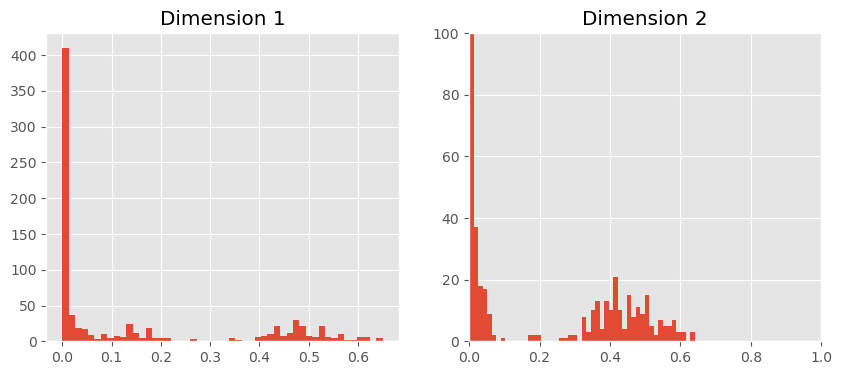

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
axes[0].set_title("Dimension 1")
plt.xlim([0,1])
plt.ylim([0,100])

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
axes[1].set_title("Dimension 2")
plt.xlim([0,1])
plt.ylim([0,100])
plt.show()

In [5]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels = np.concatenate((labels_1, labels_2))
labels_3 = np.ones(N3)*2
labels = np.concatenate((labels, labels_3))
labels_4 = np.ones(N4)*3
labels = np.concatenate((labels, labels_4))
labels_5 = np.ones(N5)*4
labels = np.concatenate((labels, labels_5))
labels_6 = np.ones(N6)*5
labels = np.concatenate((labels, labels_6))

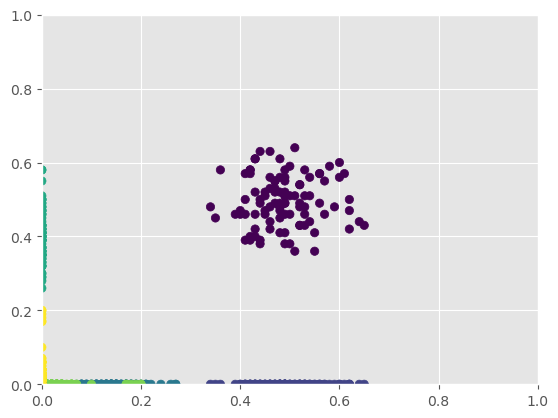

In [6]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

RUN WITH K = 5 AND SEED = 40
NV = 0 before: tensor(784)
delta_param tensor([[[0.5993, 0.4007],
         [0.4009, 0.5991]],

        [[0.6042, 0.3958],
         [0.4047, 0.5953]],

        [[0.3989, 0.6011],
         [0.4042, 0.5958]],

        [[0.3960, 0.6040],
         [0.6048, 0.3952]],

        [[0.3962, 0.6038],
         [0.6040, 0.3960]]], grad_fn=<DivBackward0>)
Iteration 0: Loss = 4432509.725186348
Iteration 200: Loss = 3919892.994614601
Iteration 400: Loss = 4841469.04792881
Iteration 600: Loss = 3835838.844315529
Iteration 800: Loss = 3347057.1515665054
Iteration 1000: Loss = 3660971.906083107
Iteration 1200: Loss = 3337637.1972208023
Iteration 1400: Loss = 3499616.5452432632
Iteration 1600: Loss = 4314108.09480381
Iteration 1800: Loss = 3391320.9605264664
Iteration 2000: Loss = 3564773.3390665054
Iteration 2200: Loss = 3341886.923661232
Iteration 2400: Loss = 3523146.3509073257
Iteration 2600: Loss = 3375501.1325235367
Iteration 2800: Loss = 3463228.608353615


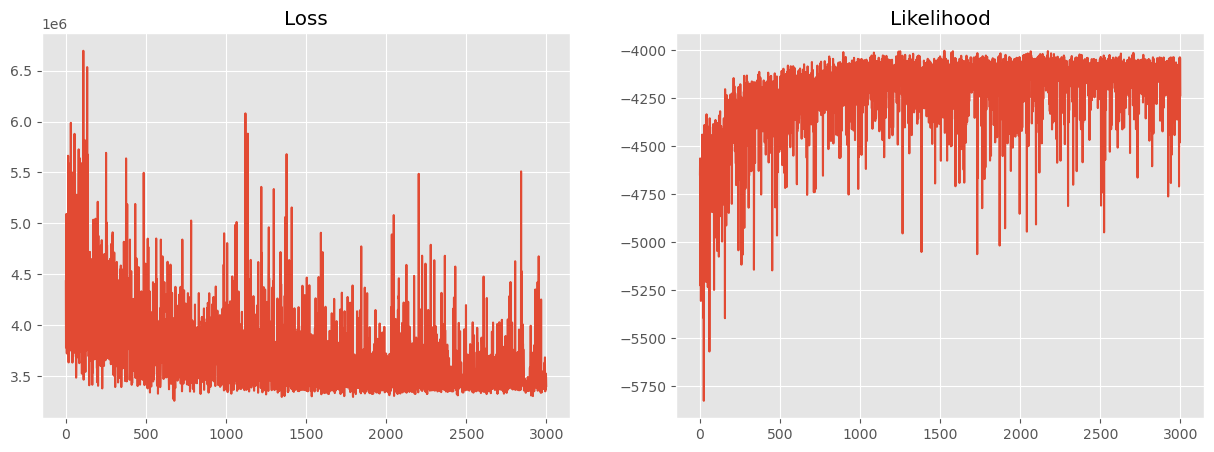

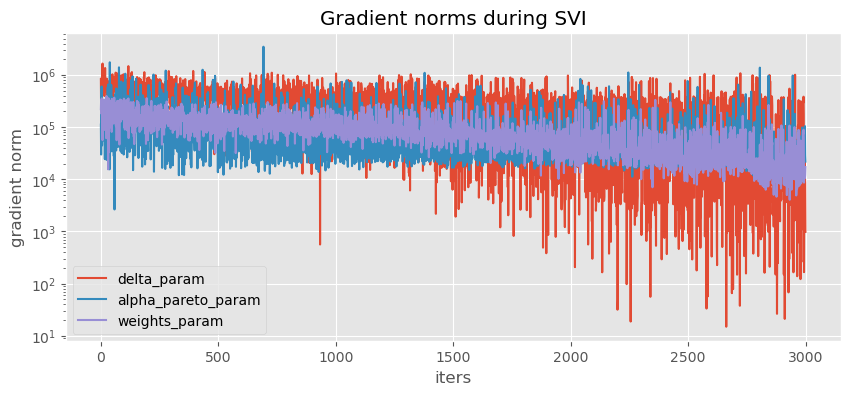

bic:  tensor(53258.1328, grad_fn=<RsubBackward1>)


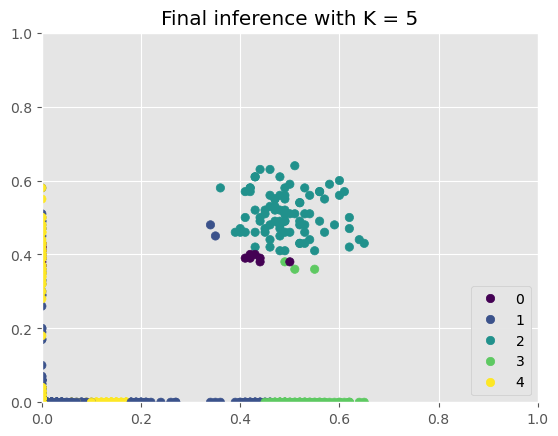

RUN WITH K = 5 AND SEED = 41
NV = 0 before: tensor(784)
delta_param tensor([[[0.6040, 0.3960],
         [0.4040, 0.5960]],

        [[0.6042, 0.3958],
         [0.4044, 0.5956]],

        [[0.4011, 0.5989],
         [0.3960, 0.6040]],

        [[0.4006, 0.5994],
         [0.6042, 0.3958]],

        [[0.4041, 0.5959],
         [0.6042, 0.3958]]], grad_fn=<DivBackward0>)
Iteration 0: Loss = 4577735.722632408
Iteration 200: Loss = 5110483.930649757
Iteration 400: Loss = 3820201.3609170914
Iteration 600: Loss = 3942096.805253029
Iteration 800: Loss = 3578155.7309122086
Iteration 1000: Loss = 3576404.428666115
Iteration 1200: Loss = 4378901.97761631
Iteration 1400: Loss = 4957518.701737404
Iteration 1600: Loss = 3405460.3062295914
Iteration 1800: Loss = 3573308.631546974
Iteration 2000: Loss = 4506035.195755959
Iteration 2200: Loss = 3402660.8928995132
Iteration 2400: Loss = 3446919.50874424
Iteration 2600: Loss = 3521506.0766153336
Iteration 2800: Loss = 3447745.2941446304


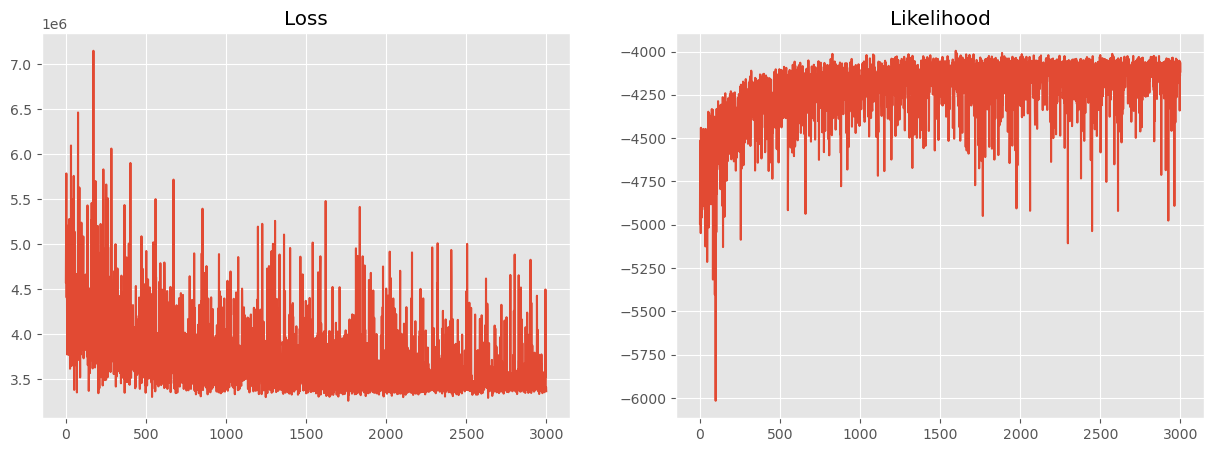

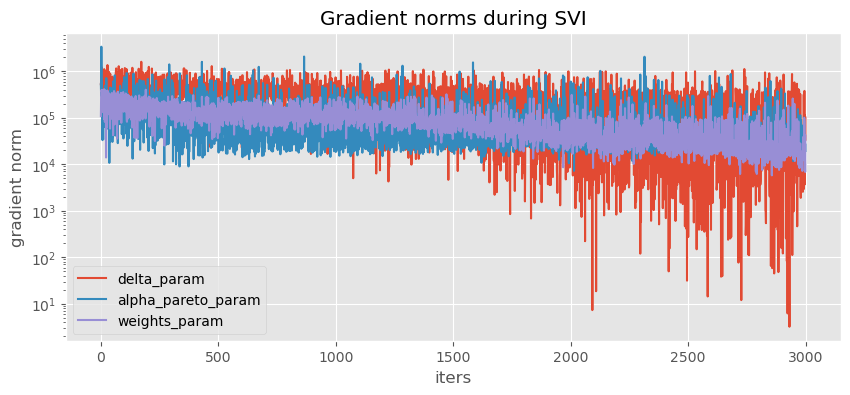

bic:  tensor(53281.9844, grad_fn=<RsubBackward1>)


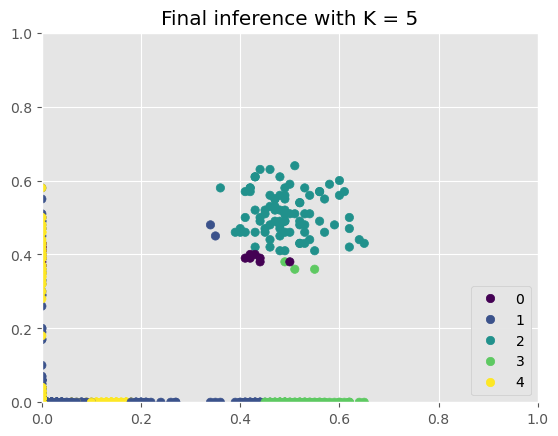

RUN WITH K = 5 AND SEED = 42
NV = 0 before: tensor(784)
delta_param tensor([[[0.5994, 0.4006],
         [0.3956, 0.6044]],

        [[0.6007, 0.3993],
         [0.4043, 0.5957]],

        [[0.4040, 0.5960],
         [0.4040, 0.5960]],

        [[0.4009, 0.5991],
         [0.5994, 0.4006]],

        [[0.4043, 0.5957],
         [0.6043, 0.3957]]], grad_fn=<DivBackward0>)
Iteration 0: Loss = 3636356.725186348
Iteration 200: Loss = 4282954.3308877945
Iteration 400: Loss = 4667443.147721291
Iteration 600: Loss = 4378897.013810158
Iteration 800: Loss = 4135665.7297525406
Iteration 1000: Loss = 3743262.2676553726
Iteration 1200: Loss = 3435894.1175088882
Iteration 1400: Loss = 3446657.6536417007
Iteration 1600: Loss = 4033567.6125040054
Iteration 1800: Loss = 4216940.821976662
Iteration 2000: Loss = 3926751.0707559586
Iteration 2200: Loss = 3476916.2688760757
Iteration 2400: Loss = 4292411.00508213
Iteration 2600: Loss = 3415549.6659708023
Iteration 2800: Loss = 3762207.870926857


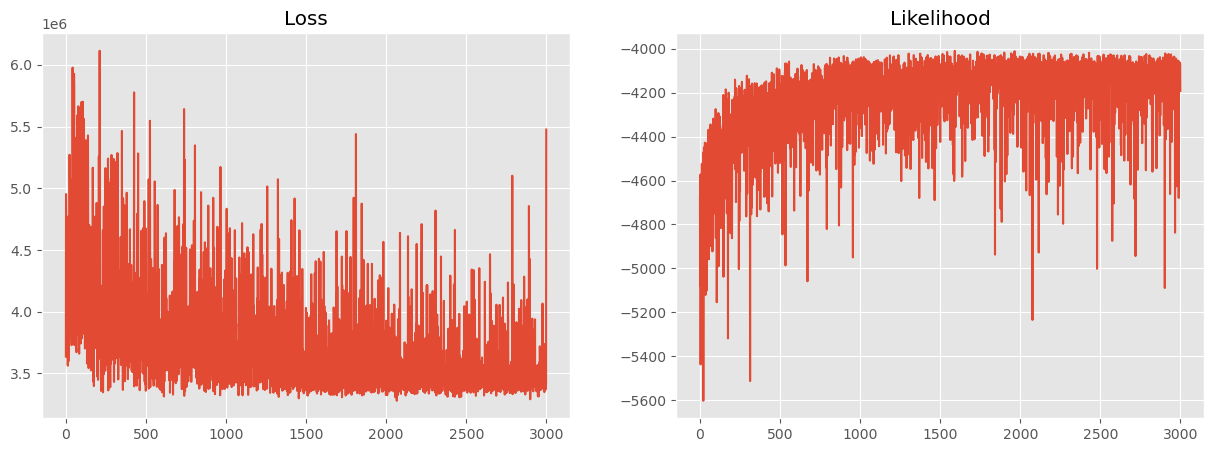

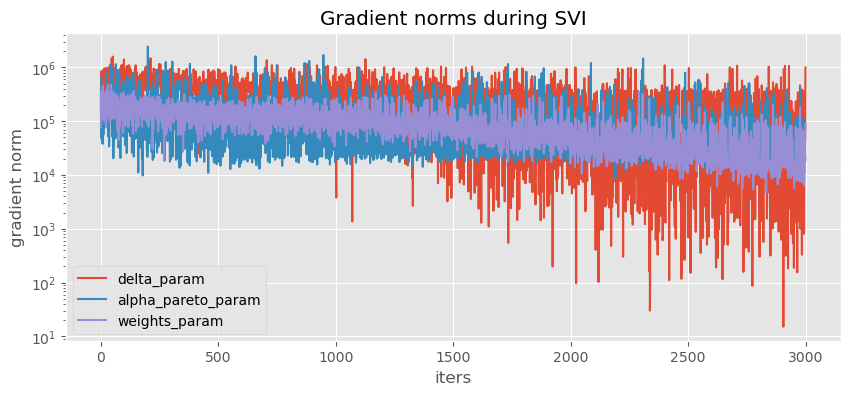

bic:  tensor(53267.5625, grad_fn=<RsubBackward1>)


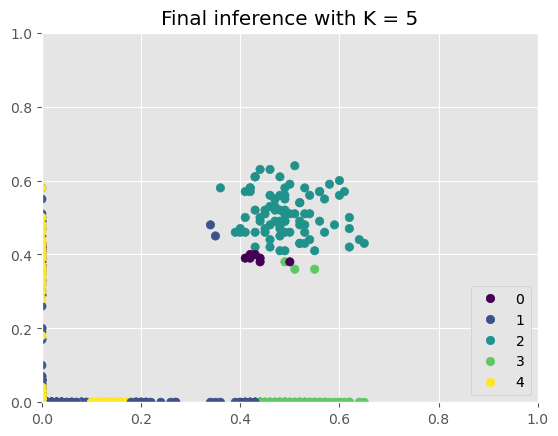

RUN WITH K = 6 AND SEED = 40
NV = 0 before: tensor(784)
delta_param tensor([[[0.6040, 0.3960],
         [0.4048, 0.5952]],

        [[0.4042, 0.5958],
         [0.3957, 0.6043]],

        [[0.4041, 0.5959],
         [0.6042, 0.3958]],

        [[0.6040, 0.3960],
         [0.3960, 0.6040]],

        [[0.4040, 0.5960],
         [0.3960, 0.6040]],

        [[0.3965, 0.6035],
         [0.6042, 0.3958]]], grad_fn=<DivBackward0>)
Iteration 0: Loss = 4451667.89938879
Iteration 200: Loss = 4172041.1191248894
Iteration 400: Loss = 3873870.915450573
Iteration 600: Loss = 3911551.9325404167
Iteration 800: Loss = 4043231.5372157097
Iteration 1000: Loss = 3344048.383834362
Iteration 1200: Loss = 3965328.697799206
Iteration 1400: Loss = 3888320.5735316277
Iteration 1600: Loss = 3591867.2883753777
Iteration 1800: Loss = 3394277.8386683464
Iteration 2000: Loss = 3499918.5249476433
Iteration 2200: Loss = 3462929.8262171745
Iteration 2400: Loss = 3450205.1644740105
Iteration 2600: Loss = 3622215.6488490

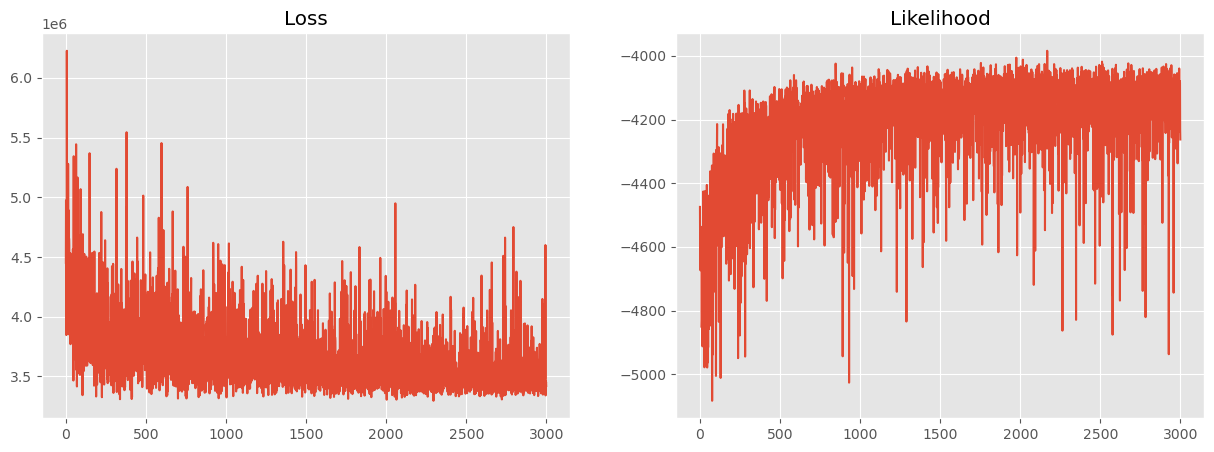

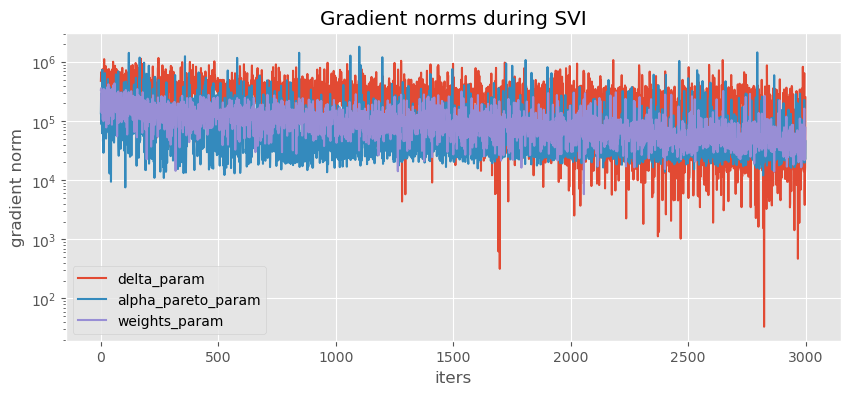

bic:  tensor(58719.1602, grad_fn=<RsubBackward1>)


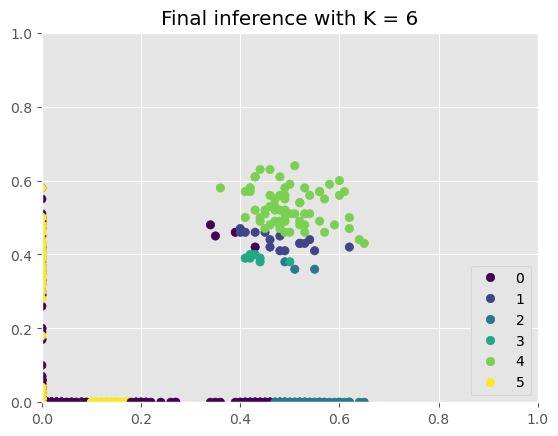

RUN WITH K = 6 AND SEED = 41
NV = 0 before: tensor(784)
delta_param tensor([[[0.6044, 0.3956],
         [0.4045, 0.5955]],

        [[0.3958, 0.6042],
         [0.4012, 0.5988]],

        [[0.4048, 0.5952],
         [0.6042, 0.3958]],

        [[0.6007, 0.3993],
         [0.4042, 0.5958]],

        [[0.4044, 0.5956],
         [0.4006, 0.5994]],

        [[0.4034, 0.5966],
         [0.6041, 0.3959]]], grad_fn=<DivBackward0>)
Iteration 0: Loss = 4075023.3968348503
Iteration 200: Loss = 3608847.7007288933
Iteration 400: Loss = 4206914.942183971
Iteration 600: Loss = 3769523.24235487
Iteration 800: Loss = 3454589.4054408073
Iteration 1000: Loss = 3382474.792037487
Iteration 1200: Loss = 3422828.324019909
Iteration 1400: Loss = 3371944.538497448
Iteration 1600: Loss = 3510631.8262171745
Iteration 1800: Loss = 3377914.887740612
Iteration 2000: Loss = 3411922.059249401
Iteration 2200: Loss = 3499199.566207409
Iteration 2400: Loss = 3576699.6175990105
Iteration 2600: Loss = 3481939.681930065
I

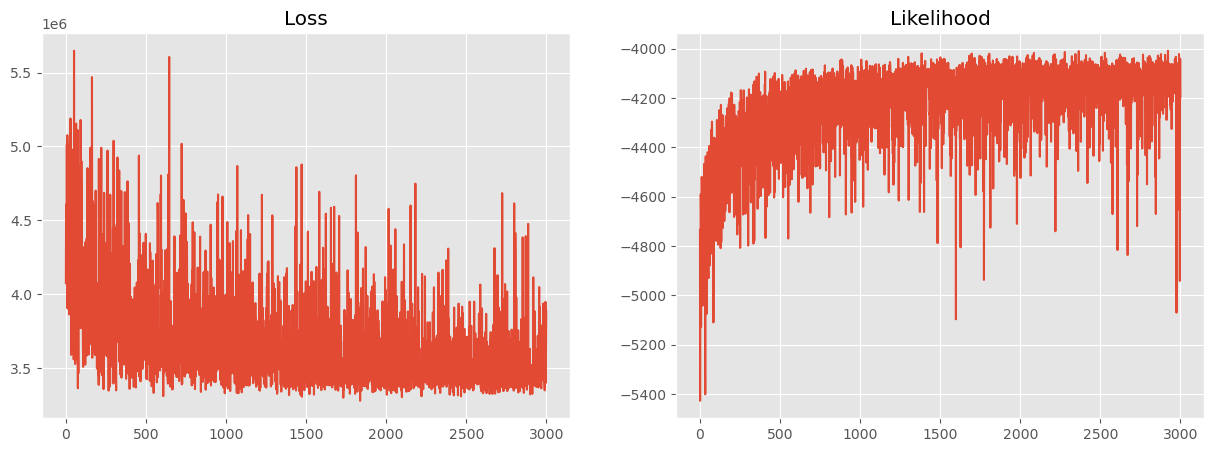

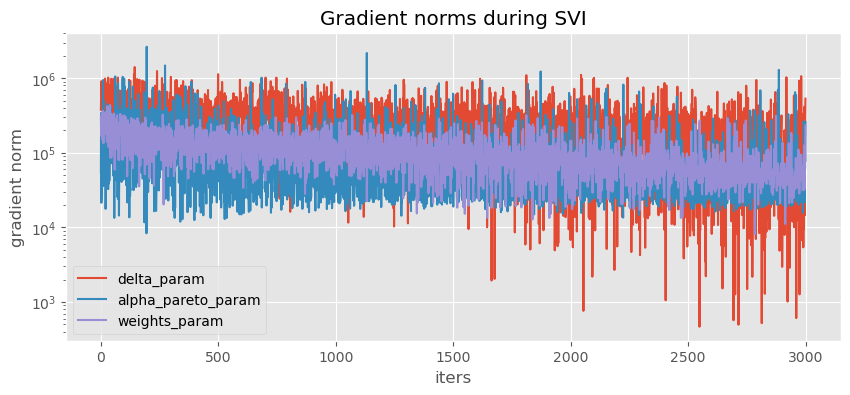

bic:  tensor(58756.7852, grad_fn=<RsubBackward1>)


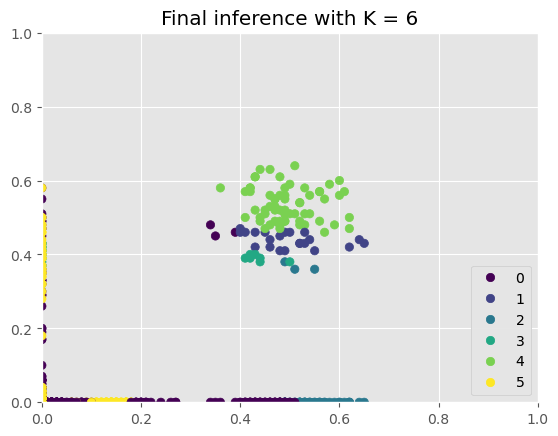

RUN WITH K = 6 AND SEED = 42
NV = 0 before: tensor(784)
delta_param tensor([[[0.6042, 0.3958],
         [0.4041, 0.5959]],

        [[0.4043, 0.5957],
         [0.3966, 0.6034]],

        [[0.4006, 0.5994],
         [0.6040, 0.3960]],

        [[0.3960, 0.6040],
         [0.4041, 0.5959]],

        [[0.3953, 0.6047],
         [0.4042, 0.5958]],

        [[0.3994, 0.6006],
         [0.6040, 0.3960]]], grad_fn=<DivBackward0>)
Iteration 0: Loss = 4197495.387744427
Iteration 200: Loss = 3570435.786910534
Iteration 400: Loss = 3613587.172103405
Iteration 600: Loss = 3600639.5546717644
Iteration 800: Loss = 3788671.0519251823
Iteration 1000: Loss = 3611038.1699671745
Iteration 1200: Loss = 3683935.163985729
Iteration 1400: Loss = 3613242.5160365105
Iteration 1600: Loss = 3679169.811080456
Iteration 1800: Loss = 3555791.806930065
Iteration 2000: Loss = 4248690.283980846
Iteration 2200: Loss = 3841889.7180628777
Iteration 2400: Loss = 3387354.80888319
Iteration 2600: Loss = 3453005.270553112
I

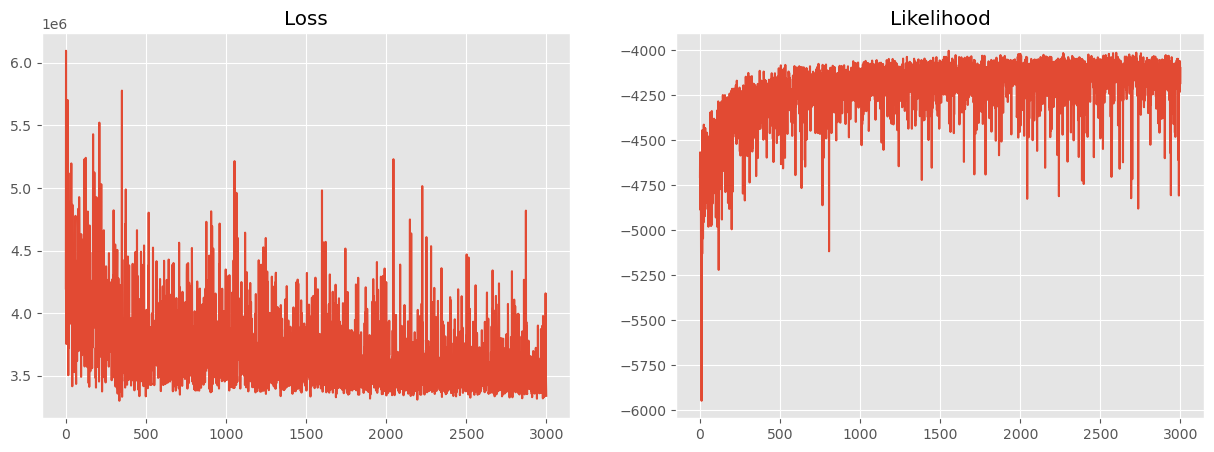

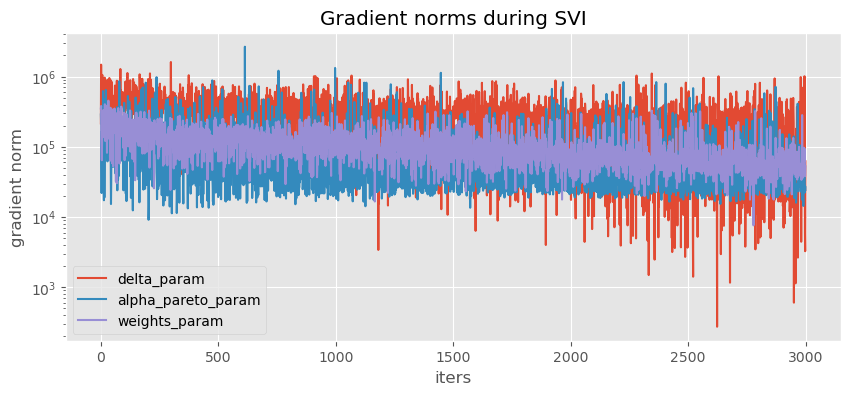

bic:  tensor(58761.9180, grad_fn=<RsubBackward1>)


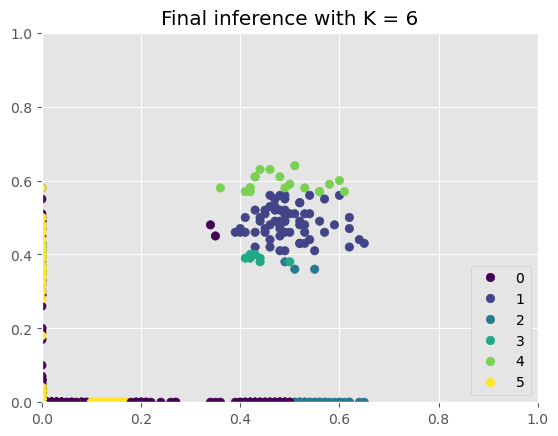

Selected number of clusters is 5 with seed 40


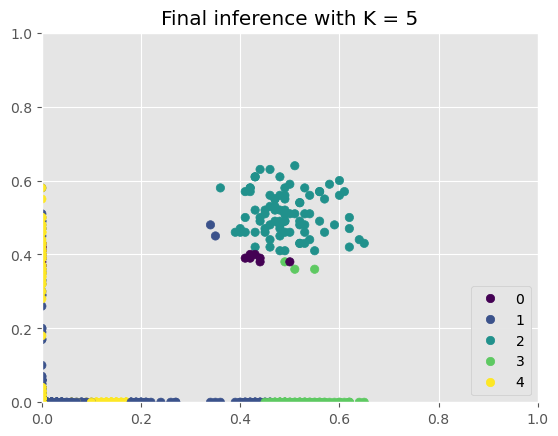

In [7]:
final_mb, mb_list = model_mobster_mv.fit(NV, DP, num_iter = 3000, K = [5,6], seed = [40,41,42], lr = 0.005)

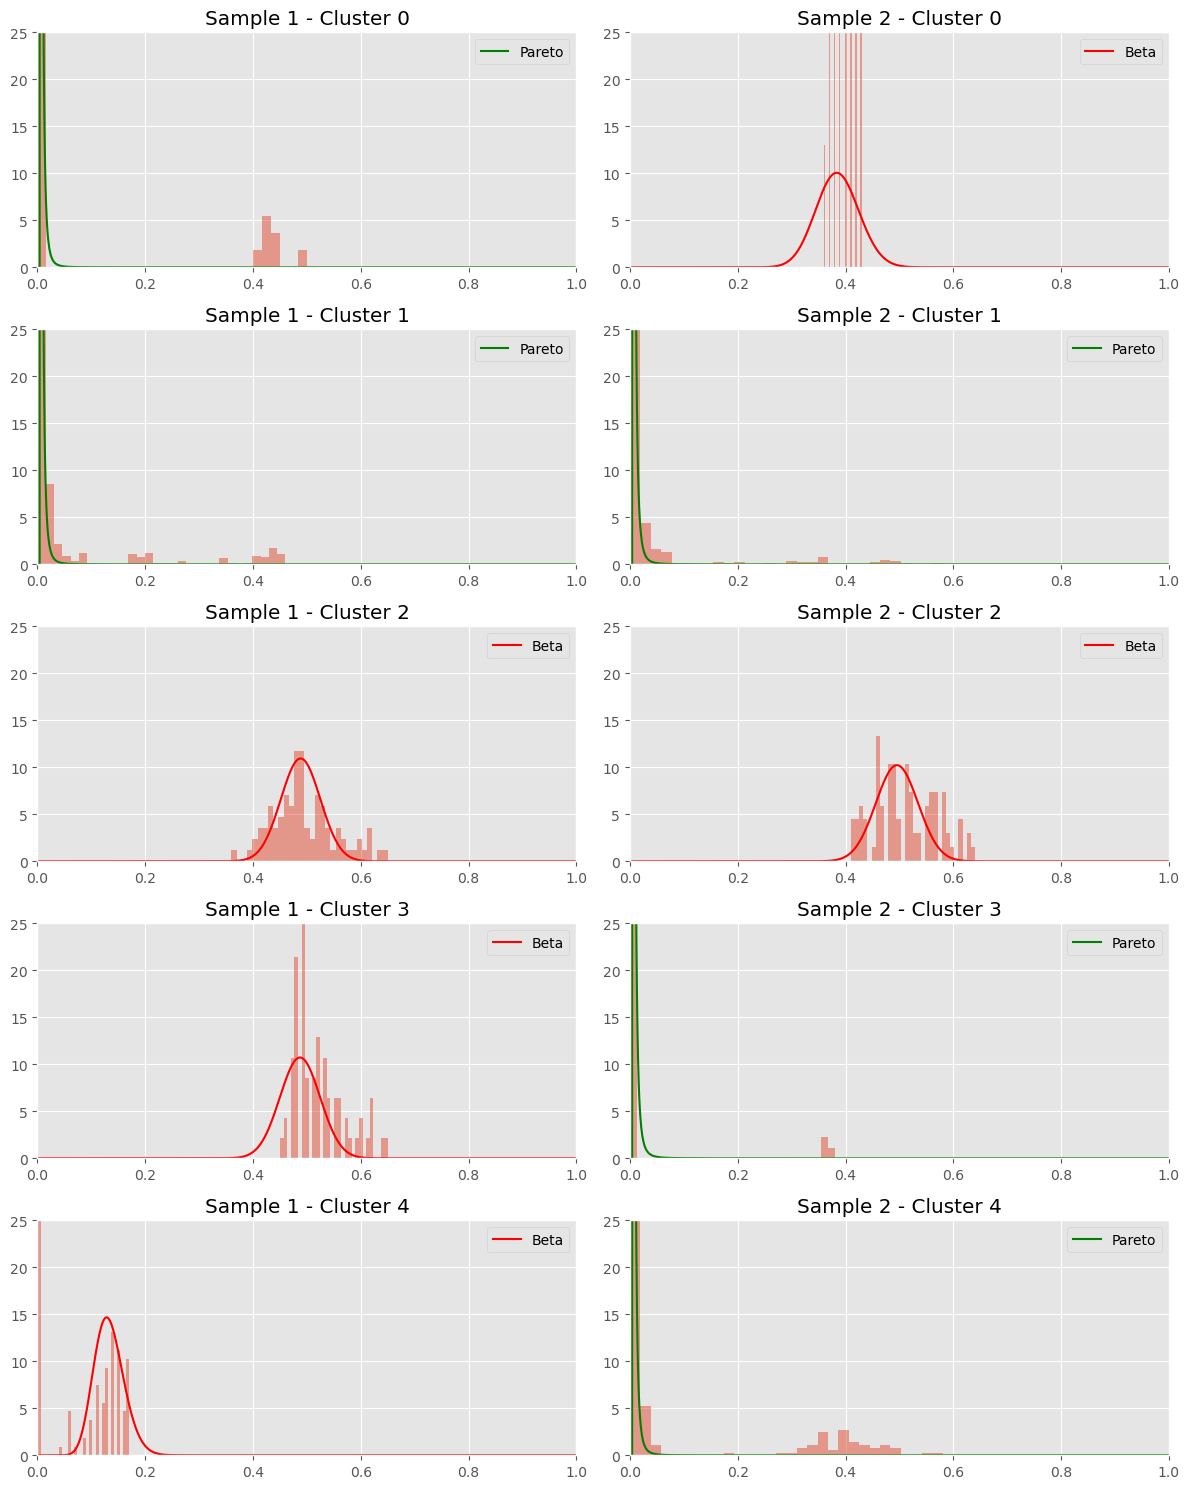

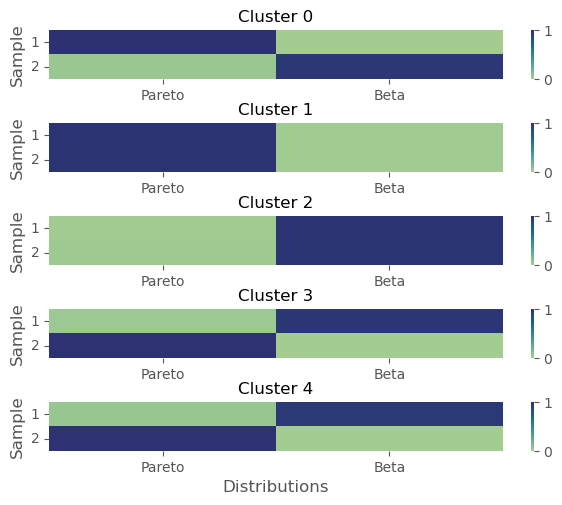

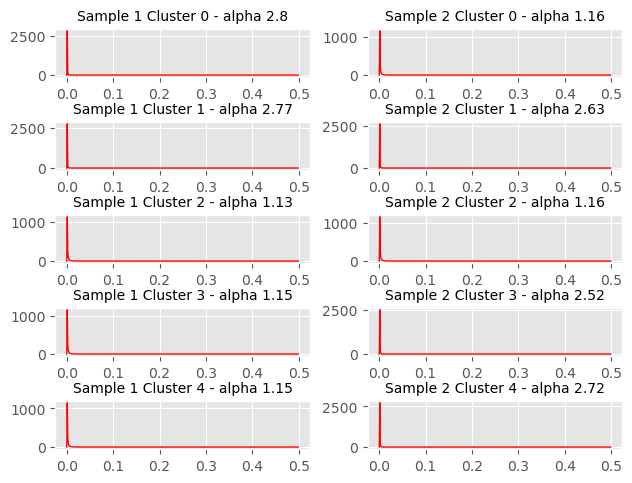

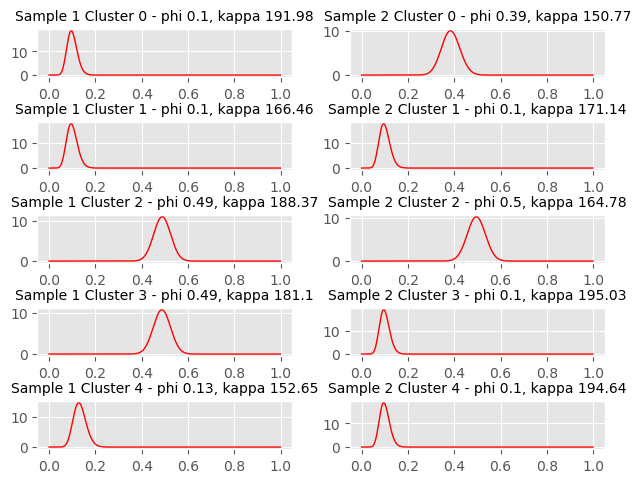

In [8]:
plot_marginals(final_mb)
plot_deltas(final_mb)
plot_paretos(final_mb)
plot_betas(final_mb)

In [9]:
final_mb.params

{'weights_param': tensor([0.1412, 0.4408, 0.1292, 0.1287, 0.1600], dtype=torch.float64,
        grad_fn=<DivBackward0>),
 'alpha_pareto_param': tensor([[2.8041, 1.1589],
         [2.7735, 2.6346],
         [1.1281, 1.1569],
         [1.1522, 2.5154],
         [1.1457, 2.7204]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[0.1000, 0.3851],
         [0.1000, 0.1000],
         [0.4883, 0.4954],
         [0.4872, 0.1000],
         [0.1331, 0.1000]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[191.9771, 150.7672],
         [166.4554, 171.1367],
         [188.3702, 164.7767],
         [181.1007, 195.0250],
         [152.6520, 194.6408]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[0.9929, 0.0071],
          [0.0396, 0.9604]],
 
         [[0.9852, 0.0148],
          [0.9853, 0.0147]],
 
         [[0.0149, 0.9851],
          [0.0258, 0.9742]],
 
         [[0.0324, 0.9676],
          [0.9892, 0.0108]],
 
         [[0.0493, 0.9507],
          [0.9897, 0.0103]]], grad_fn=<Di

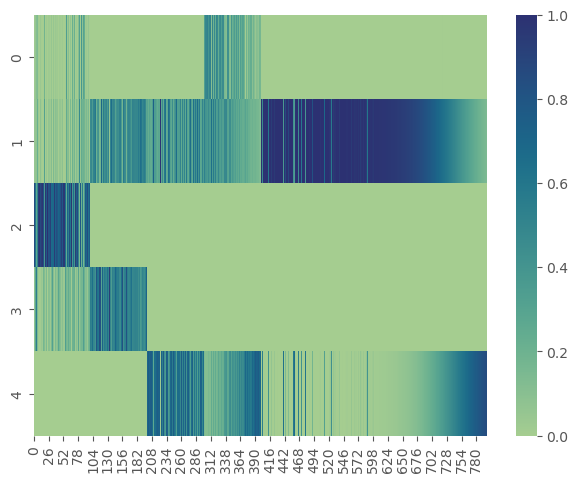

In [10]:
plot_responsib(final_mb)

### Reconstructed rRACES longitudinal data 

In [5]:
N1 = 80
N2 = 80
N3 = 80
N4 = 80
N5 = 400
N6 = 400
seed = 123
# Component 1
alpha_pareto = 1.2
L_pareto = 0.01
H_pareto = 0.5
phi_beta = 0.5
k_beta = 200
n1 = 100
NV1, DP1 = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n1, N=N1, seed = seed)


# Component 2
phi_beta_x = 0.5
k_beta_x = 150
phi_beta_y = 0.5
k_beta_y= 150
n2=150
NV2, DP2 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n2, N=N2, seed=seed)
NV = torch.concat((NV1,NV2))
DP = torch.concat((DP1,DP2))

# Component 3
phi_beta_x = 0.25
k_beta_x = 100
phi_beta_y = 1e-10
k_beta_y= 100
n3=150
NV3, DP3 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n3, N=N3, seed=seed)
NV3[:,1] = torch.tensor(0, dtype=NV3.dtype)
NV = torch.concat((NV,NV3))
DP = torch.concat((DP,DP3))


# Component 4
phi_beta_x = 1e-10
k_beta_x = 150
phi_beta_y = 0.25
k_beta_y= 150
n4=150
NV4, DP4 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n4, N=N4, seed=seed)
NV4[:,0] = torch.tensor(0, dtype=NV4.dtype)
NV = torch.concat((NV,NV4))
DP = torch.concat((DP,DP4))


# Component 5
alpha_pareto = 1.5
phi_beta = 1e-10
k_beta = 150
n5=150
NV5, DP5 = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n5, N=N5,exchanged = False, seed = seed)
NV5[:,1] = torch.tensor(0, dtype=NV1.dtype)
NV = torch.concat((NV,NV5))
DP = torch.concat((DP,DP5))
print(NV.shape)
print(DP.shape)


# Component 6
alpha_pareto = 1.5
phi_beta = 1e-10
k_beta = 150
n6=150
NV6, DP6 = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n5, N=N5, exchanged = True, seed = seed)
NV6[:,0] = torch.tensor(0, dtype=NV6.dtype)
NV = torch.concat((NV,NV6))
DP = torch.concat((DP,DP6))

torch.Size([720, 2])
torch.Size([720, 2])


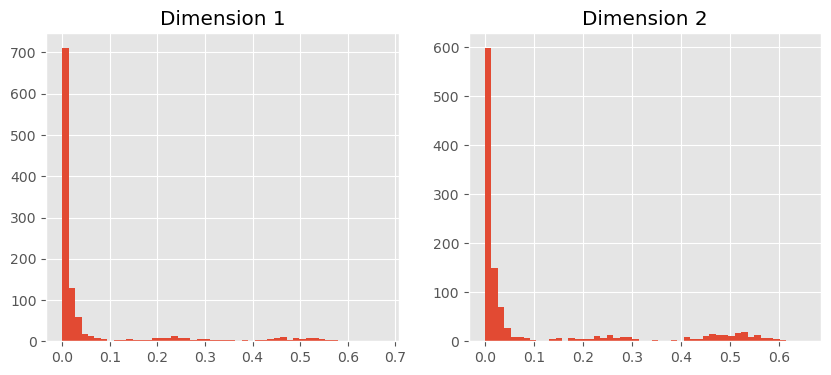

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
axes[0].set_title("Dimension 1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
axes[1].set_title("Dimension 2")
plt.show()

In [9]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels = np.concatenate((labels_1, labels_2))
labels_3 = np.ones(N3)*2
labels = np.concatenate((labels, labels_3))
labels_4 = np.ones(N4)*3
labels = np.concatenate((labels, labels_4))
labels_5 = np.ones(N5)*4
labels = np.concatenate((labels, labels_5))
labels_6 = np.ones(N6)*5
labels = np.concatenate((labels, labels_6))

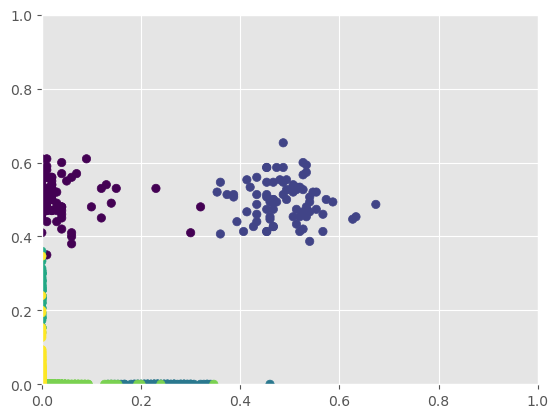

In [10]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

RUN WITH K = 5 AND SEED = 40
NV = 0 before: tensor(1053)
delta_param tensor([[[0.3992, 0.6008],
         [0.6043, 0.3957]],

        [[0.4042, 0.5958],
         [0.4043, 0.5957]],

        [[0.4041, 0.5959],
         [0.4043, 0.5957]],

        [[0.3960, 0.6040],
         [0.6046, 0.3954]],

        [[0.5994, 0.4006],
         [0.3953, 0.6047]]], grad_fn=<DivBackward0>)
Iteration 0: Loss = 9654021.220826149
Iteration 200: Loss = 9367152.824601173
Iteration 400: Loss = 7481357.677445412
Iteration 600: Loss = 9627810.784623146
Iteration 800: Loss = 7851566.806962013
Iteration 1000: Loss = 7838936.966996193
Iteration 1200: Loss = 7925623.105912209
Iteration 1400: Loss = 7322845.545609474
Iteration 1600: Loss = 7047449.958451271
Iteration 1800: Loss = 7935721.141068459
Iteration 2000: Loss = 7161458.272904396
Iteration 2200: Loss = 7110062.566117287
Iteration 2400: Loss = 7008516.839066505
Iteration 2600: Loss = 8021738.026566505
Iteration 2800: Loss = 8112688.485795021


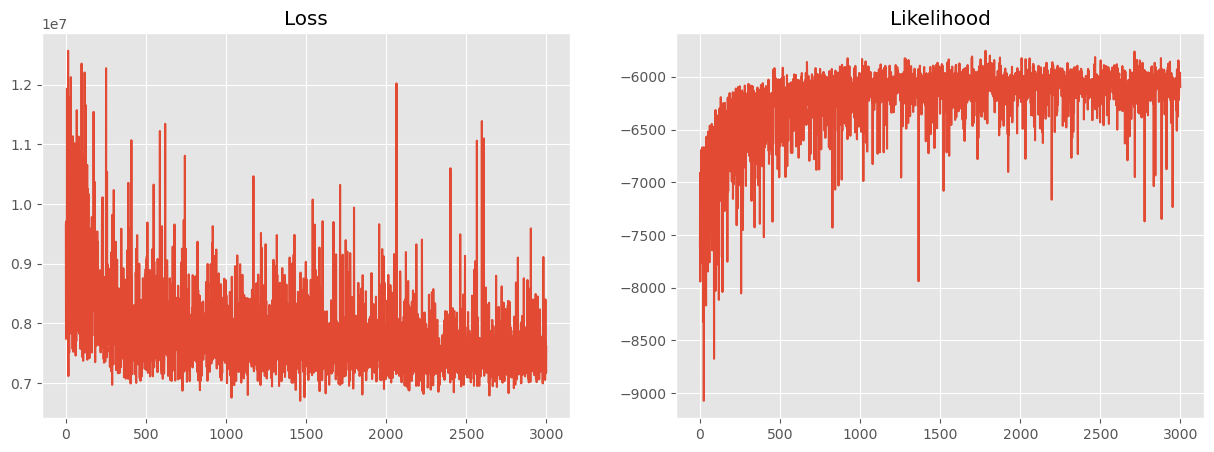

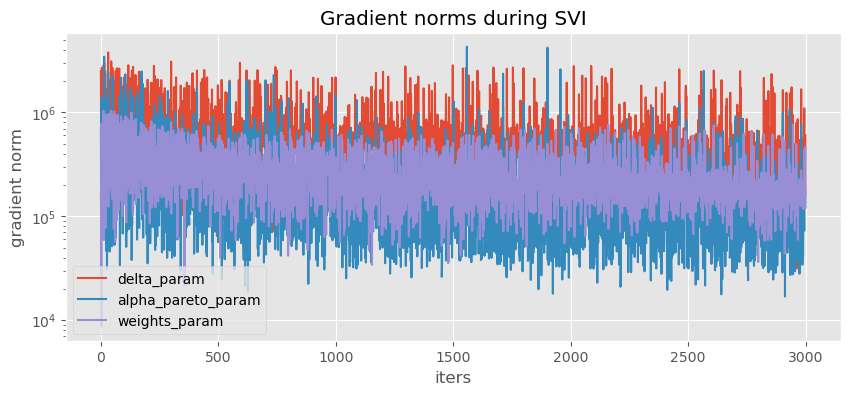

bic:  tensor(72828.2031, grad_fn=<RsubBackward1>)


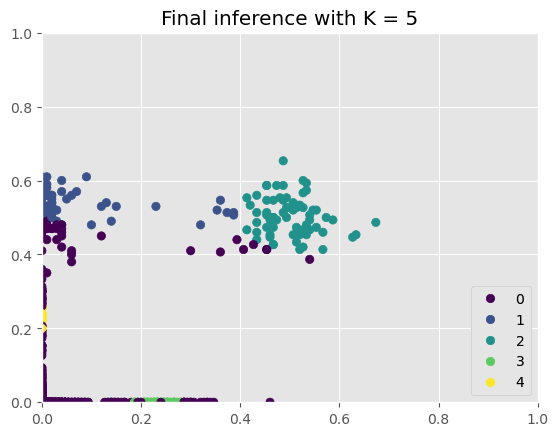

RUN WITH K = 5 AND SEED = 41
NV = 0 before: tensor(1053)
delta_param tensor([[[0.4041, 0.5959],
         [0.6040, 0.3960]],

        [[0.3993, 0.6007],
         [0.4006, 0.5994]],

        [[0.4009, 0.5991],
         [0.3962, 0.6038]],

        [[0.4006, 0.5994],
         [0.6042, 0.3958]],

        [[0.6040, 0.3960],
         [0.3993, 0.6007]]], grad_fn=<DivBackward0>)
Iteration 0: Loss = 10695384.230294228
Iteration 200: Loss = 10507391.818985939
Iteration 400: Loss = 8418031.268143654
Iteration 600: Loss = 7846247.978714943
Iteration 800: Loss = 8434046.187821388
Iteration 1000: Loss = 7407747.862626076
Iteration 1200: Loss = 8173099.833695412
Iteration 1400: Loss = 7088856.502640724
Iteration 1600: Loss = 7598677.297318459
Iteration 1800: Loss = 7746735.603714943
Iteration 2000: Loss = 7399972.744095802
Iteration 2200: Loss = 7678873.084671974
Iteration 2400: Loss = 7566512.968949318
Iteration 2600: Loss = 7695179.449662209
Iteration 2800: Loss = 7200892.668656349


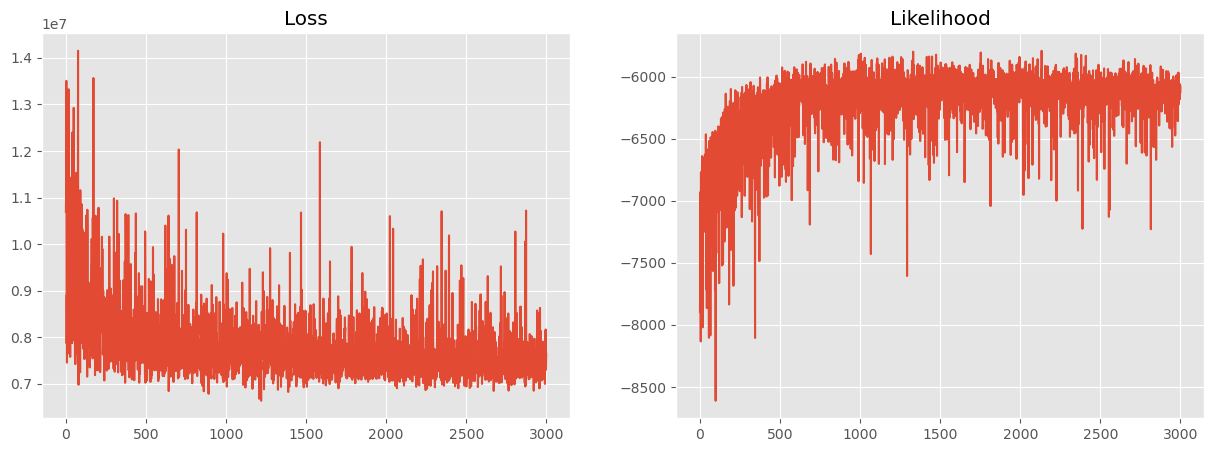

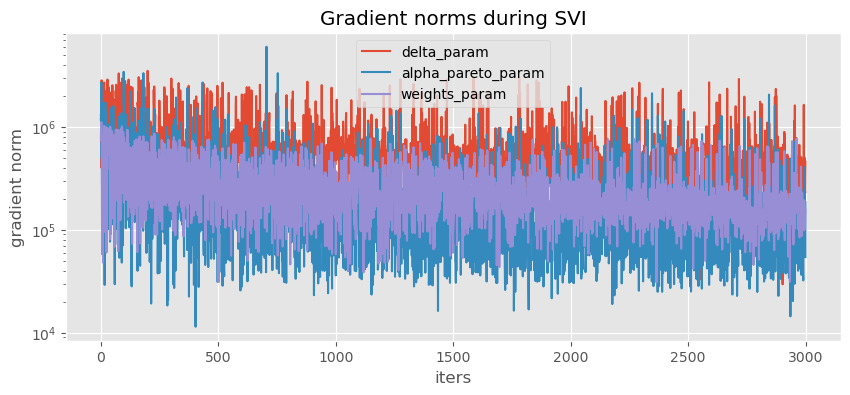

bic:  tensor(72856.3750, grad_fn=<RsubBackward1>)


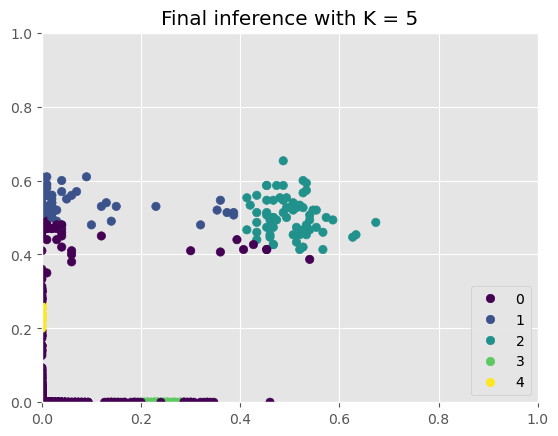

Selected number of clusters is 5 with seed 40


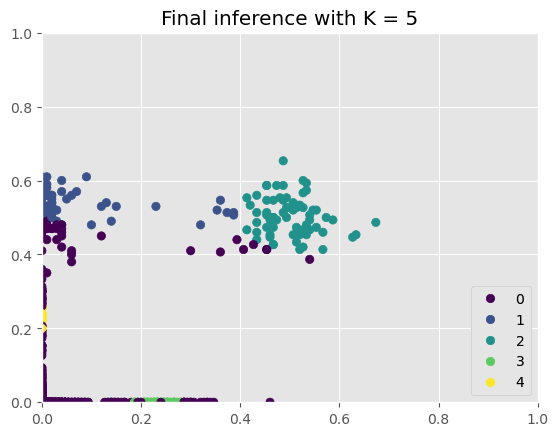

In [11]:
final_mb, mb_list = model_mobster_mv.fit(NV, DP, num_iter = 3000, K = [5], seed = [40,41], lr = 0.005)

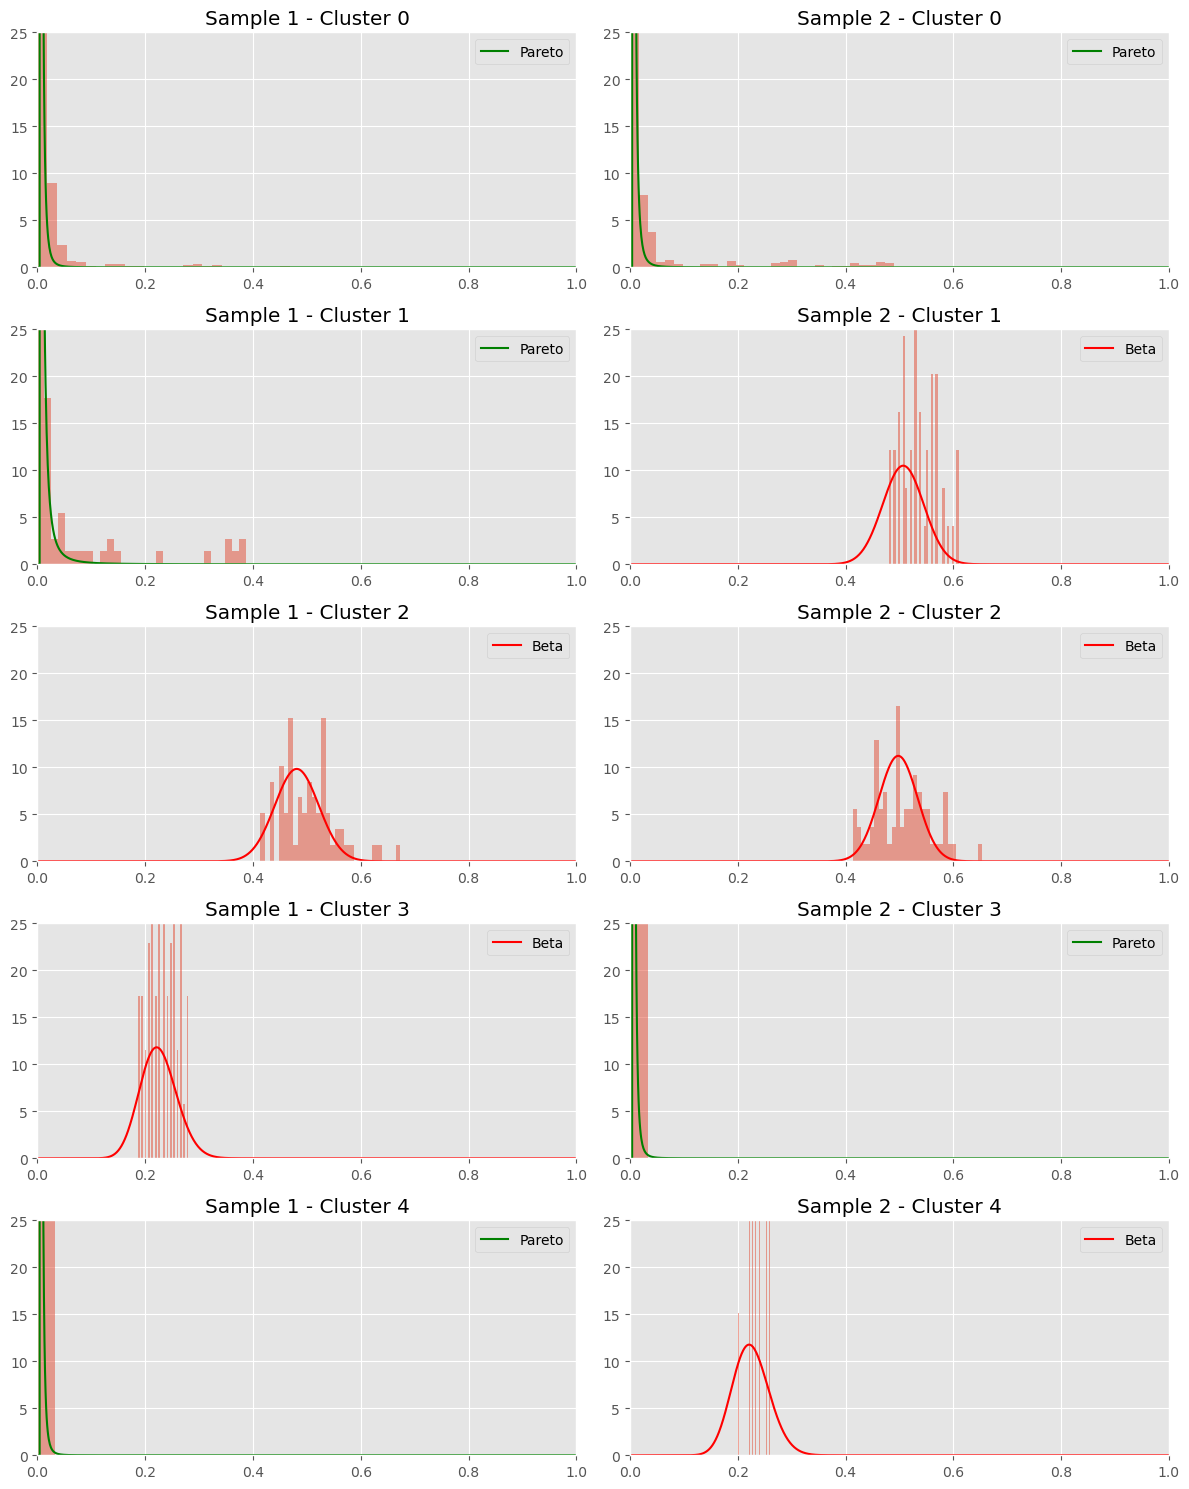

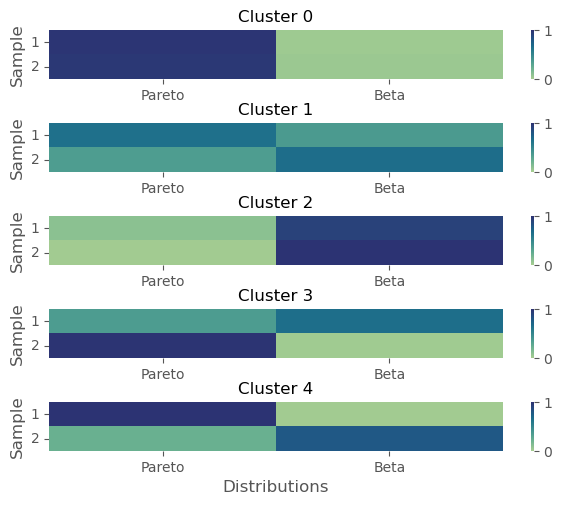

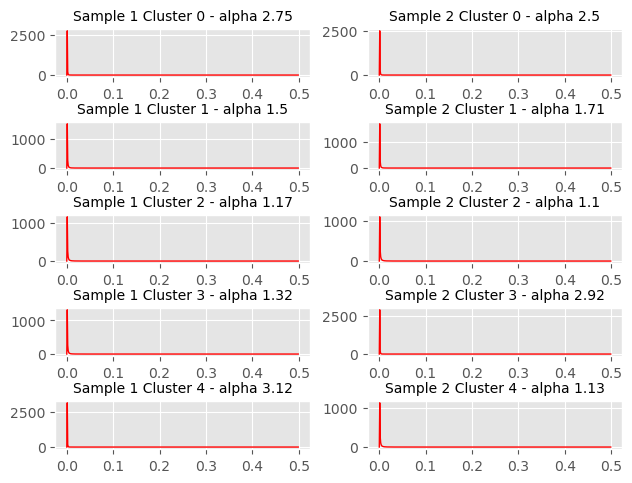

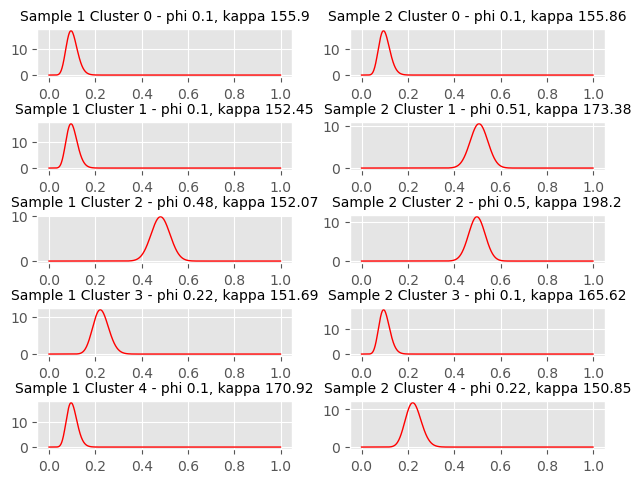

In [14]:
plot_marginals(final_mb)
plot_deltas(final_mb)
plot_paretos(final_mb)
plot_betas(final_mb)

In [15]:
final_mb.params

{'weights_param': tensor([0.5100, 0.1151, 0.0874, 0.1550, 0.1324], dtype=torch.float64,
        grad_fn=<DivBackward0>),
 'alpha_pareto_param': tensor([[2.7466, 2.5024],
         [1.5048, 1.7101],
         [1.1652, 1.0987],
         [1.3189, 2.9221],
         [3.1201, 1.1291]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[0.1000, 0.1000],
         [0.1000, 0.5069],
         [0.4813, 0.4978],
         [0.2247, 0.1000],
         [0.1000, 0.2248]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[155.8959, 155.8638],
         [152.4528, 173.3756],
         [152.0714, 198.1994],
         [151.6937, 165.6187],
         [170.9223, 150.8453]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[0.9734, 0.0266],
          [0.9623, 0.0377]],
 
         [[0.6389, 0.3611],
          [0.3413, 0.6587]],
 
         [[0.0928, 0.9072],
          [0.0155, 0.9845]],
 
         [[0.3500, 0.6500],
          [0.9808, 0.0192]],
 
         [[0.9848, 0.0152],
          [0.2176, 0.7824]]], grad_fn=<Di

### rRACES data

In [6]:
NV_r = pd.read_csv("./rRACES_data/NV2.csv")
DP_r = pd.read_csv("./rRACES_data/DP2.csv")

NV = torch.tensor(NV_r.to_numpy())
DP = torch.tensor(DP_r.to_numpy())

print(NV.shape)
print(DP.shape)

torch.Size([593, 2])
torch.Size([593, 2])


In [7]:
# Replace zeros with a large value that will not be considered as minimum
vaf = NV[:,0]/DP[:,0]
copy_vaf = torch.clone(vaf)
masked_tensor = copy_vaf.masked_fill(vaf == 0, float(1.))

# Find the minimum value excluding zeros
min_value = torch.min(masked_tensor)
print(min_value)

# Replace zeros with a large value that will not be considered as minimum
vaf = NV[:,1]/DP[:,1]
copy_vaf = torch.clone(vaf)
masked_tensor = copy_vaf.masked_fill(vaf == 0, float(1.))

# Find the minimum value excluding zeros
min_value = torch.min(masked_tensor)
print(min_value)

tensor(0.0097)
tensor(0.0092)


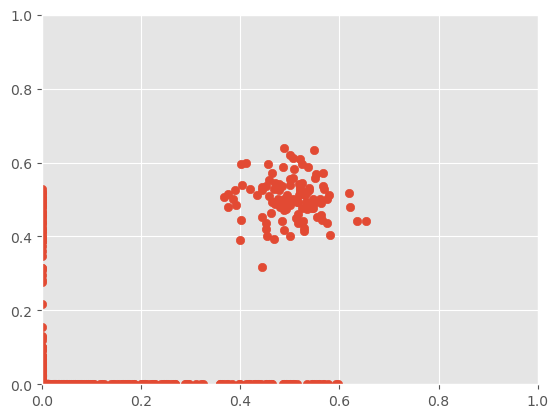

In [8]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1])

In [9]:
torch.sum((NV[:,0] == 0) & (NV[:,1]/DP[:,1] < 0.18))

tensor(159)

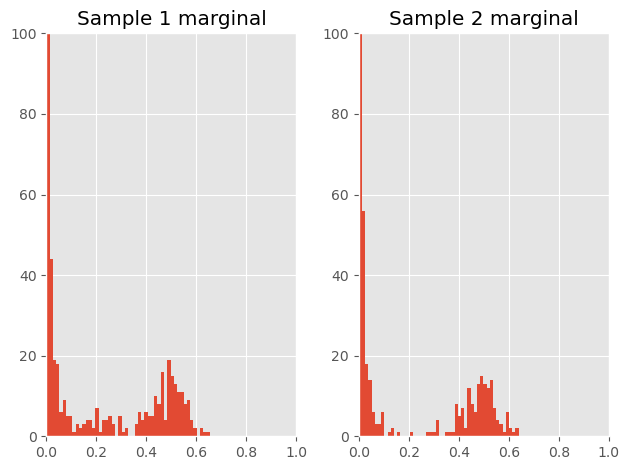

In [10]:
# First subplot for Sample 1 marginal
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
# Plot marginal of S1
plt.hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
plt.title("Sample 1 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Second subplot for Sample 2 marginal
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
plt.title("Sample 2 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Display the plots
plt.tight_layout()
plt.show()

kmeans_centers:  tensor([[2.1703e-01, 4.4703e-08],
        [4.9993e-01, 5.0346e-01],
        [1.0000e-03, 4.2671e-01],
        [4.6957e-01, 4.4703e-08],
        [1.4685e-02, 1.4474e-02]])
Cluster Sizes: [ 50 105  46  58 334]
Cluster Sizes Vector: [0.08431703 0.17706577 0.07757167 0.09780776 0.56323777]
Cluster variances [[331.7503658  331.7503658 ]
 [150.79538045 150.79538045]
 [218.94510456 218.94510456]
 [253.59698898 253.59698898]
 [856.990159   856.990159  ]]


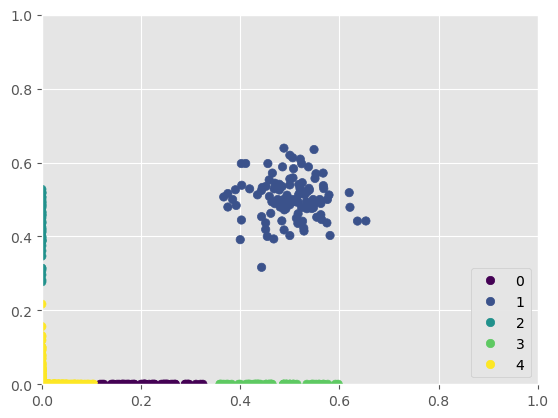

In [11]:
from sklearn.cluster import KMeans
K = 5
kmeans = KMeans(n_clusters=K, random_state=123, n_init=2).fit((NV/DP).numpy())
labels = kmeans.labels_
centers = torch.tensor(kmeans.cluster_centers_)
centers[centers <= 0] = 0.001
centers[centers >= 1] = 0.999

print("kmeans_centers: ", centers)

plt.xlim([0,1])
plt.ylim([0,1])
sc = plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)
legend1 = plt.legend(*sc.legend_elements(), loc="lower right")
plt.gca().add_artist(legend1)

# print(labels.astype(int))
# Compute cluster sizes
cluster_sizes = np.bincount(labels.astype(int), minlength=K)
print("Cluster Sizes:", cluster_sizes)

# Convert to a 1D vector
cluster_sizes_vector = cluster_sizes.reshape(-1)/np.sum(cluster_sizes.reshape(-1))
print("Cluster Sizes Vector:", cluster_sizes_vector)

centroids = kmeans.cluster_centers_
variances = []
for i in range(kmeans.n_clusters):
    vaf = NV/DP
    points_in_cluster = vaf[labels == i]
    
    # Get the centroid of the current cluster
    centroid = centroids[i]

    # Calculate the squared distances of points to the centroid
    distances = np.linalg.norm(points_in_cluster - centroid, axis=1) ** 2

    # Compute the variance (mean of squared distances)
    cluster_variance = np.mean(distances)
    variances.append(cluster_variance)

kappas = [1 / variance if variance > 0 else np.inf for variance in variances]
kappas = np.tile(kappas, (NV.shape[1], 1)).T
print("Cluster variances", kappas)

RUN WITH K = 5 AND SEED = 40
NV = 0 before: tensor(488)
delta_param tensor([[[0.3968, 0.6032],
         [0.4010, 0.5990]],

        [[0.4042, 0.5958],
         [0.4044, 0.5956]],

        [[0.4041, 0.5959],
         [0.6042, 0.3958]],

        [[0.5960, 0.4040],
         [0.4042, 0.5958]],

        [[0.3960, 0.6040],
         [0.6038, 0.3962]]], grad_fn=<DivBackward0>)
Iteration 0: Loss = 2357233.4708299637
Iteration 200: Loss = 1929413.2653360367
Iteration 400: Loss = 1944533.0431070328
Iteration 600: Loss = 2256364.257584572
Iteration 800: Loss = 2042560.9543008804
Iteration 1000: Loss = 1807326.4125528336
Iteration 1200: Loss = 2285226.619339943
Iteration 1400: Loss = 1856559.9501504898
Iteration 1600: Loss = 2044908.3368692398
Iteration 1800: Loss = 1887396.645951271
Iteration 2000: Loss = 1919795.3097696304
Iteration 2200: Loss = 1856123.6057901382
Iteration 2400: Loss = 2538888.6366739273
Iteration 2600: Loss = 1830258.2110147476
Iteration 2800: Loss = 1842710.9638223648


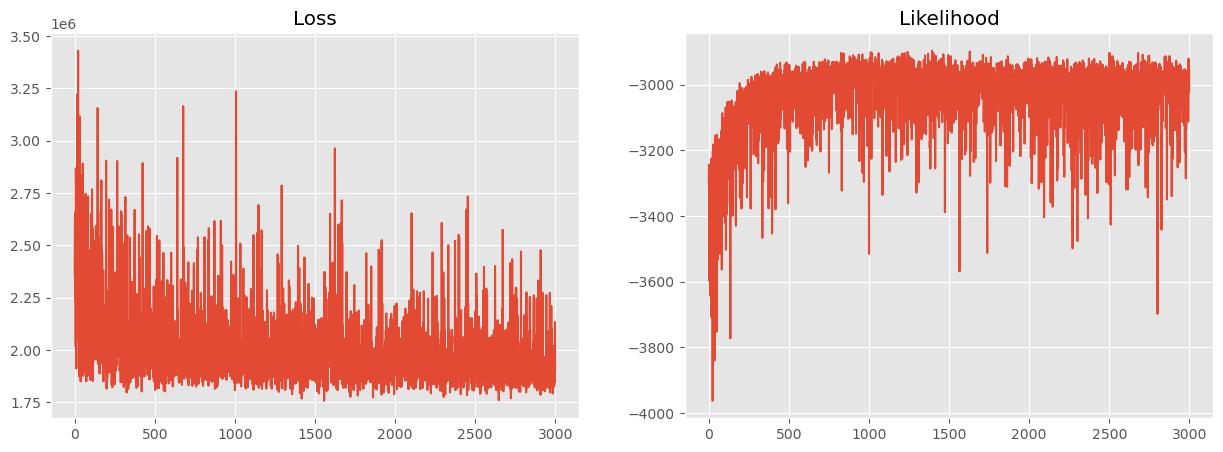

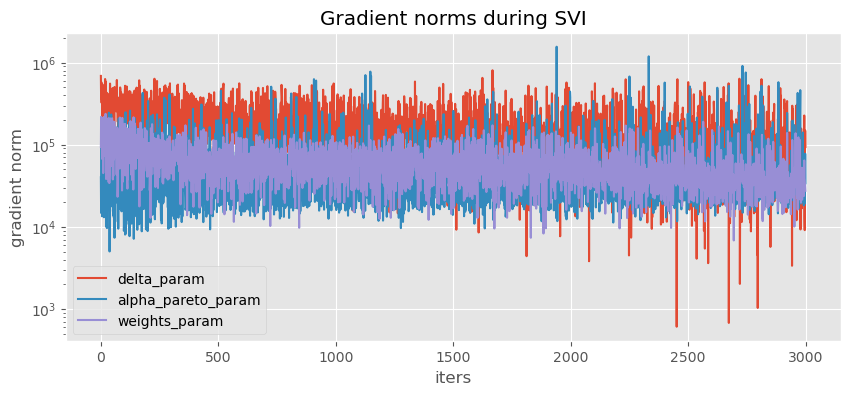

bic:  tensor(33411.6094, grad_fn=<RsubBackward1>)


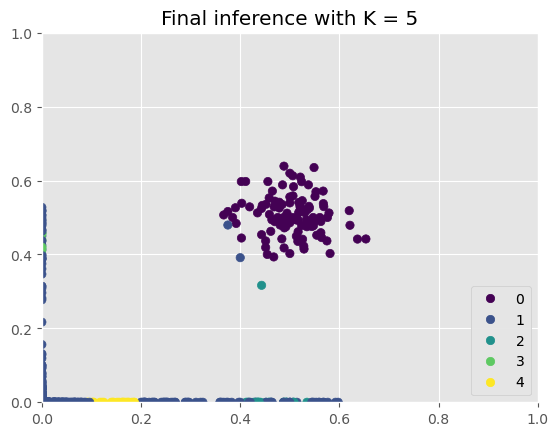

RUN WITH K = 5 AND SEED = 41
NV = 0 before: tensor(488)
delta_param tensor([[[0.4040, 0.5960],
         [0.4009, 0.5991]],

        [[0.4042, 0.5958],
         [0.4046, 0.5954]],

        [[0.4040, 0.5960],
         [0.6047, 0.3953]],

        [[0.6042, 0.3958],
         [0.4043, 0.5957]],

        [[0.4039, 0.5961],
         [0.6042, 0.3958]]], grad_fn=<DivBackward0>)
Iteration 0: Loss = 2639672.4755601883
Iteration 200: Loss = 2793159.7460184097
Iteration 400: Loss = 2426012.4964151382
Iteration 600: Loss = 1853656.2710733414
Iteration 800: Loss = 1894737.2400064468
Iteration 1000: Loss = 2325575.3870401382
Iteration 1200: Loss = 2204922.104447365
Iteration 1400: Loss = 2127158.4999551773
Iteration 1600: Loss = 1980413.6870889664
Iteration 1800: Loss = 1985976.9948282242
Iteration 2000: Loss = 1867838.612748146
Iteration 2200: Loss = 1975862.4616250992
Iteration 2400: Loss = 1991645.4816446304
Iteration 2600: Loss = 1957418.406449318
Iteration 2800: Loss = 1900306.8258829117


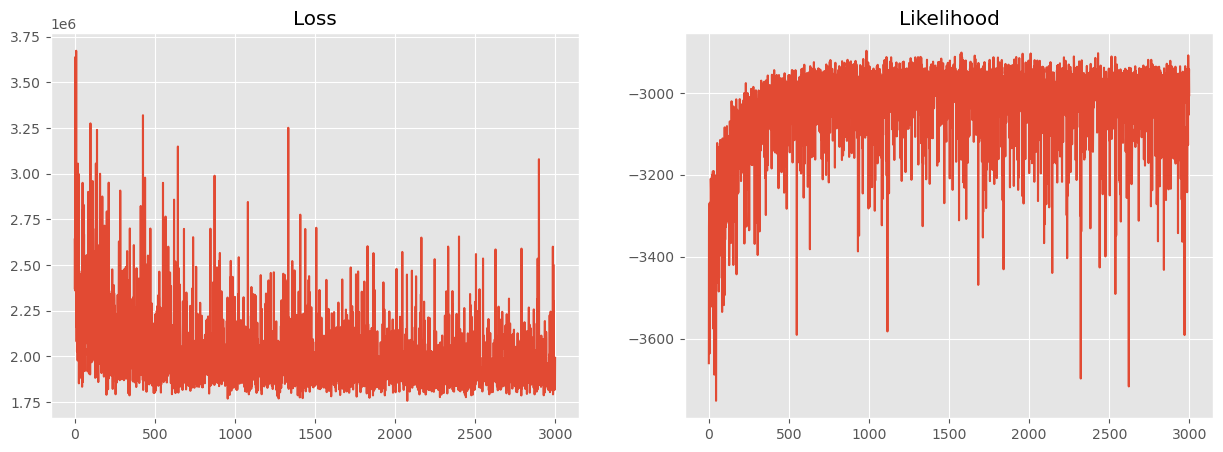

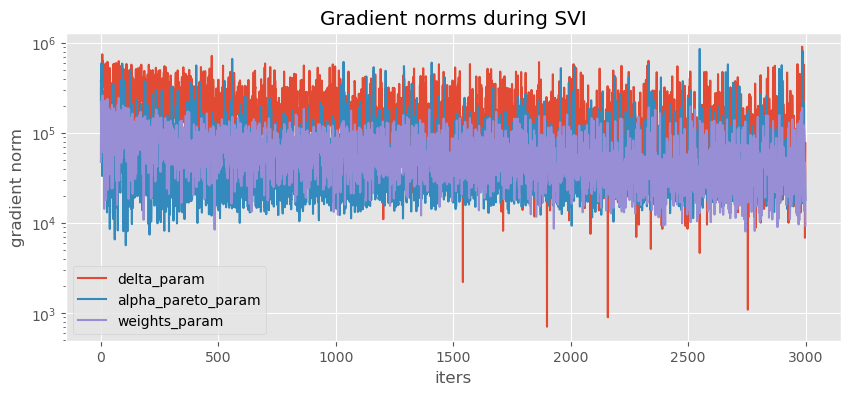

bic:  tensor(33430.0586, grad_fn=<RsubBackward1>)


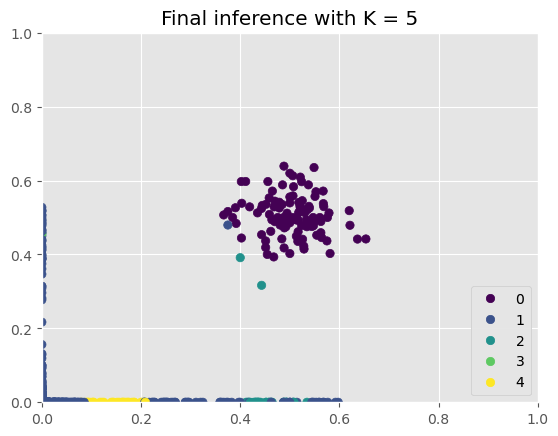

RUN WITH K = 6 AND SEED = 40
NV = 0 before: tensor(488)
delta_param tensor([[[0.4040, 0.5960],
         [0.3964, 0.6036]],

        [[0.4042, 0.5958],
         [0.4042, 0.5958]],

        [[0.4046, 0.5954],
         [0.5994, 0.4006]],

        [[0.6043, 0.3957],
         [0.3960, 0.6040]],

        [[0.4043, 0.5957],
         [0.3958, 0.6042]],

        [[0.4042, 0.5958],
         [0.5967, 0.4033]]], grad_fn=<DivBackward0>)
Iteration 0: Loss = 2790052.8975806236
Iteration 200: Loss = 2279540.547759533
Iteration 400: Loss = 2047507.0284571648
Iteration 600: Loss = 2062481.179915905
Iteration 800: Loss = 1940145.4772791862
Iteration 1000: Loss = 1873724.0305018425
Iteration 1200: Loss = 1851971.500594616
Iteration 1400: Loss = 1956590.5784754753
Iteration 1600: Loss = 1981509.7638392448
Iteration 1800: Loss = 1918386.5360560417
Iteration 2000: Loss = 1920970.6930994987
Iteration 2200: Loss = 1954458.8307948112
Iteration 2400: Loss = 2034096.0379481316
Iteration 2600: Loss = 1814414.38706

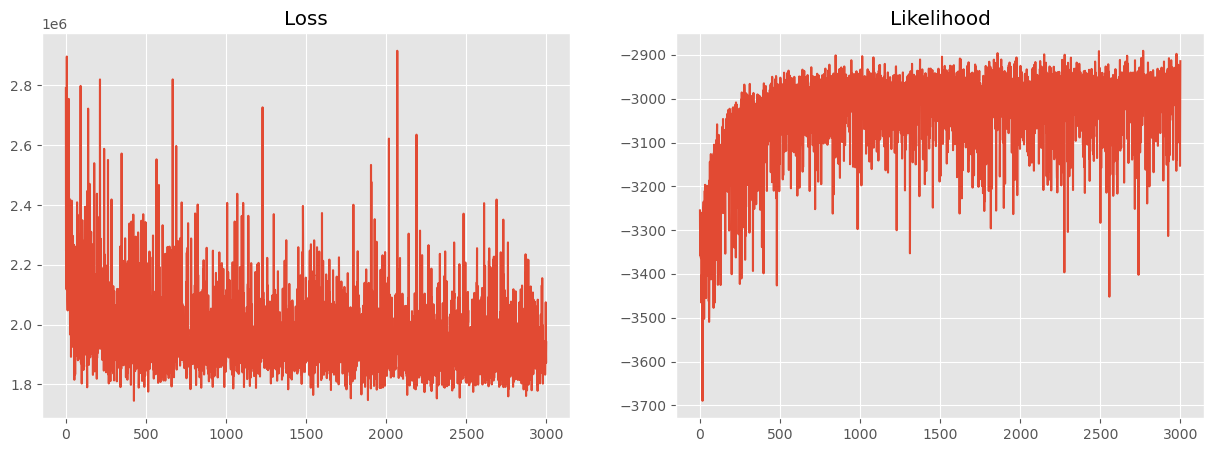

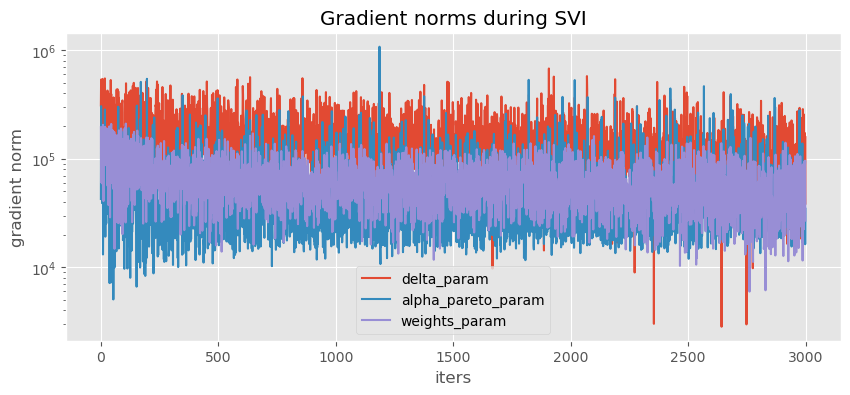

bic:  tensor(37070.8086, grad_fn=<RsubBackward1>)


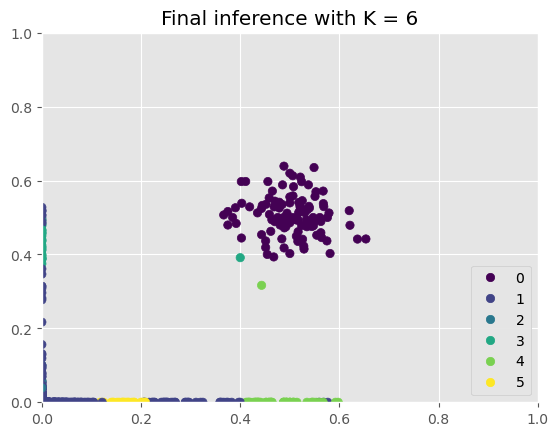

RUN WITH K = 6 AND SEED = 41
NV = 0 before: tensor(488)
delta_param tensor([[[0.4043, 0.5957],
         [0.4035, 0.5965]],

        [[0.4037, 0.5963],
         [0.4042, 0.5958]],

        [[0.4043, 0.5957],
         [0.6043, 0.3957]],

        [[0.6007, 0.3993],
         [0.4042, 0.5958]],

        [[0.4041, 0.5959],
         [0.4006, 0.5994]],

        [[0.4013, 0.5987],
         [0.6042, 0.3958]]], grad_fn=<DivBackward0>)
Iteration 0: Loss = 2164453.1548686028
Iteration 200: Loss = 1794144.9363245964
Iteration 400: Loss = 1870402.4333033562
Iteration 600: Loss = 2163778.858016491
Iteration 800: Loss = 1922552.5984339714
Iteration 1000: Loss = 2095319.6956019402
Iteration 1200: Loss = 1916455.4445033073
Iteration 1400: Loss = 1962894.6265101433
Iteration 1600: Loss = 1915971.4116053581
Iteration 1800: Loss = 1789342.3336634636
Iteration 2000: Loss = 2149551.099044323
Iteration 2200: Loss = 1871859.9714808464
Iteration 2400: Loss = 2019215.2253260612
Iteration 2600: Loss = 1818649.1152

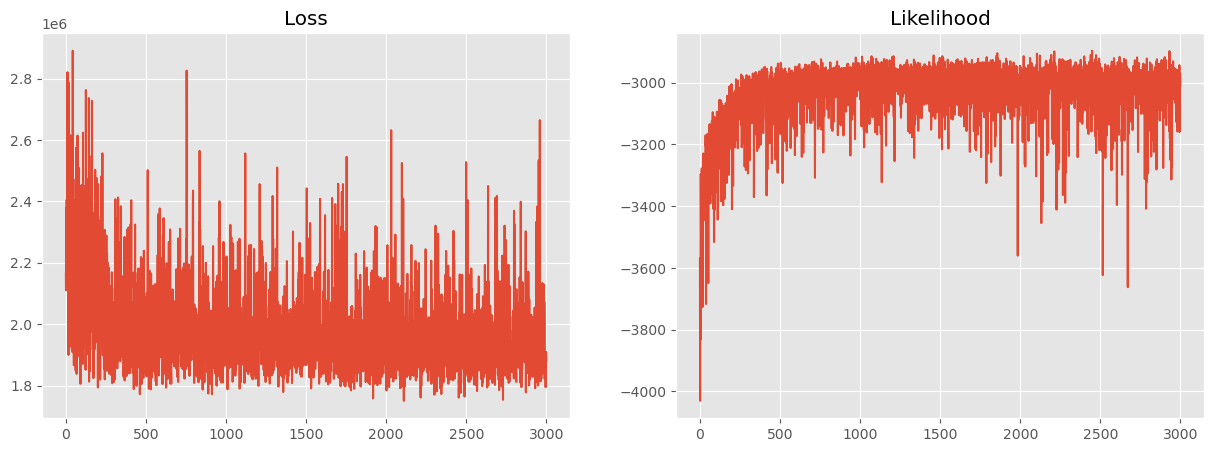

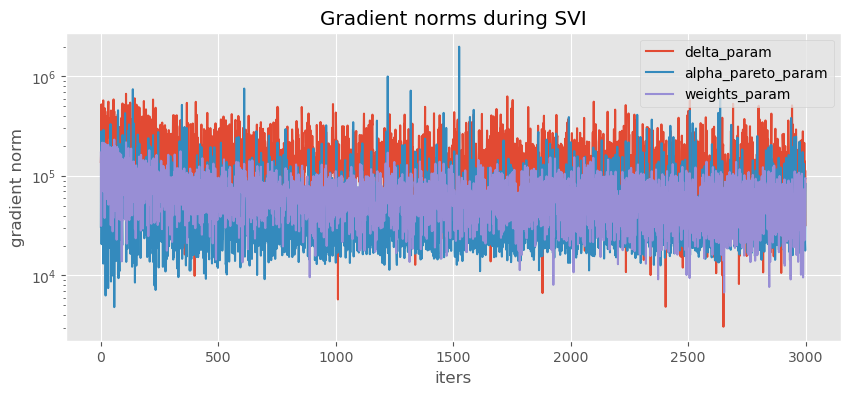

bic:  tensor(37052.9570, grad_fn=<RsubBackward1>)


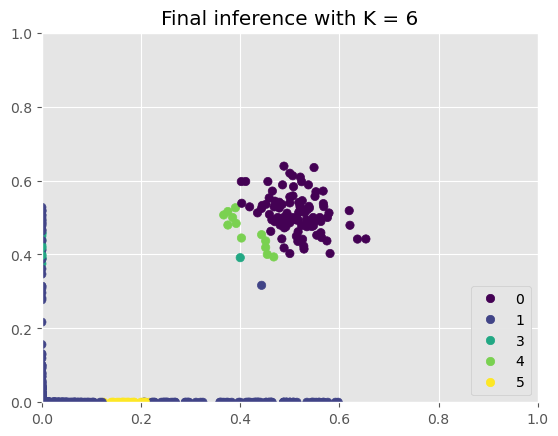

Selected number of clusters is 5 with seed 40


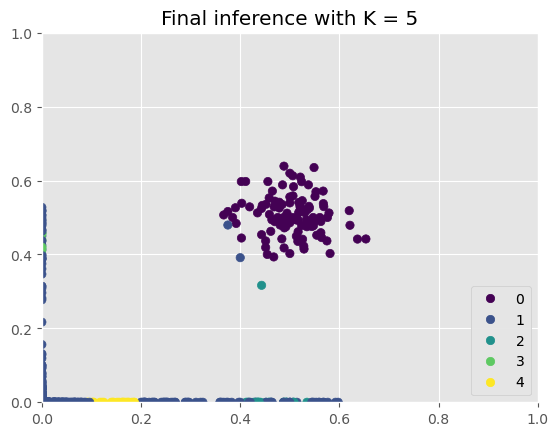

In [12]:
final_mb, mb_list = model_mobster_mv.fit(NV, DP, num_iter = 3000, K = [5,6], seed = [40,41], lr = 0.005)

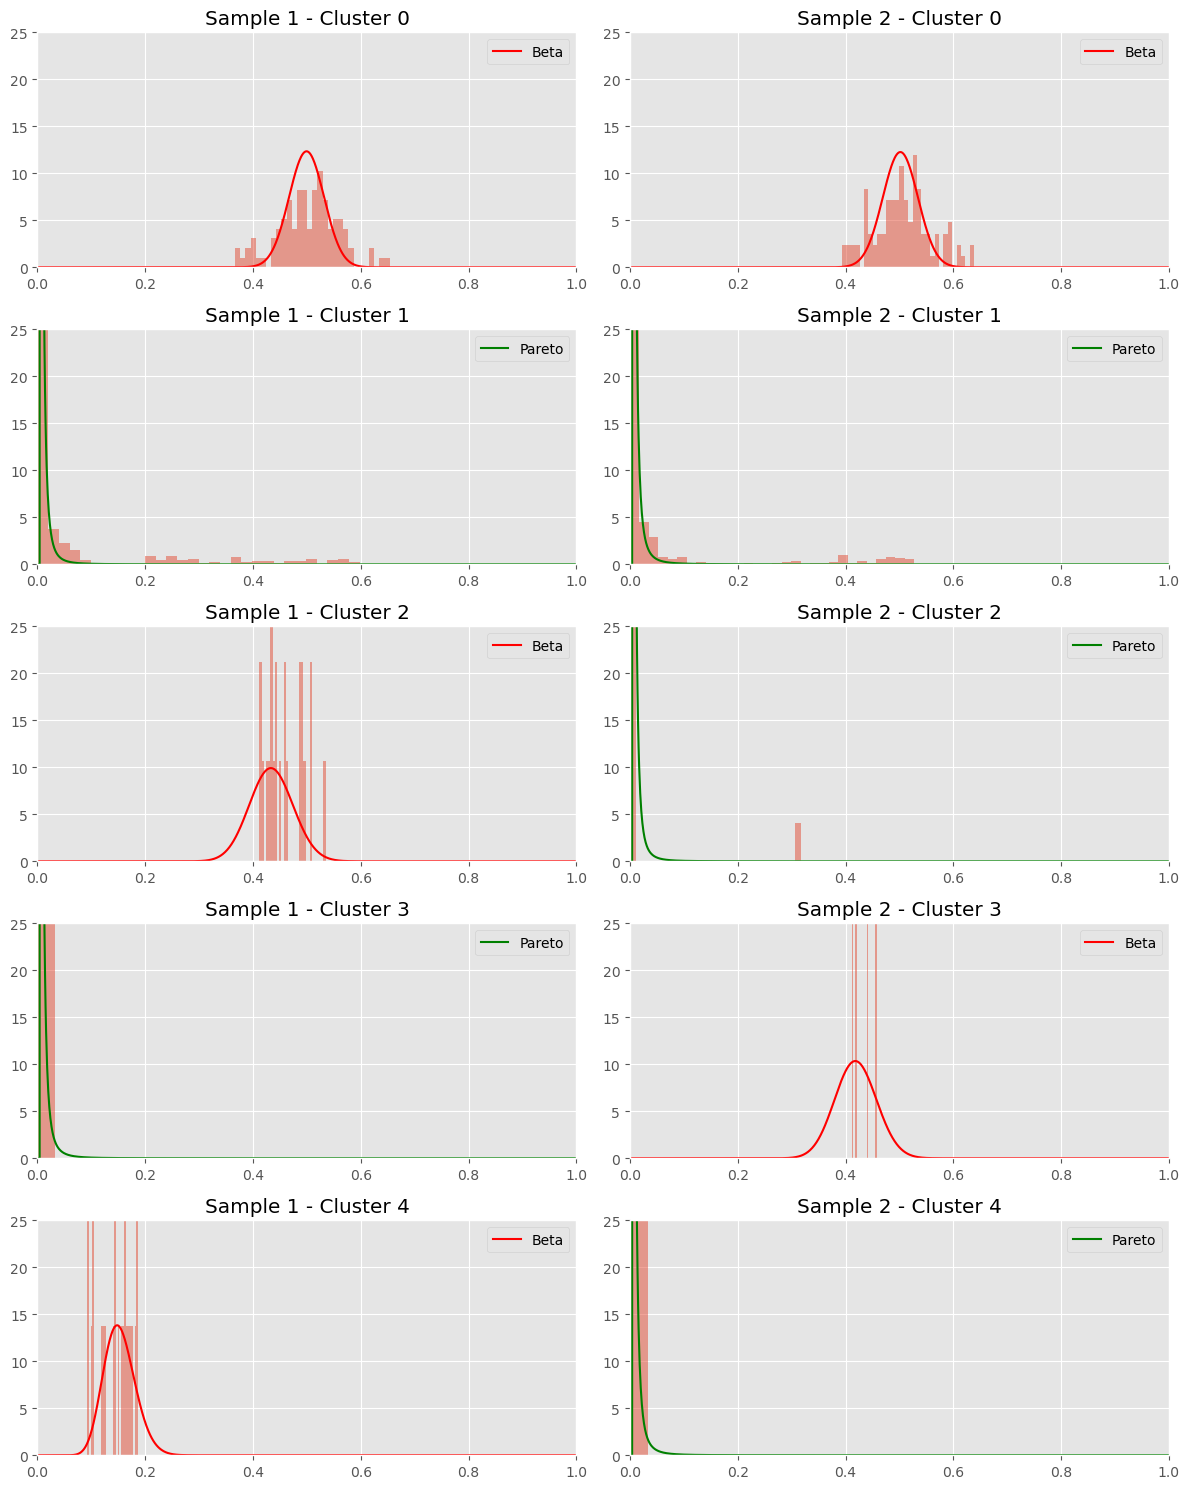

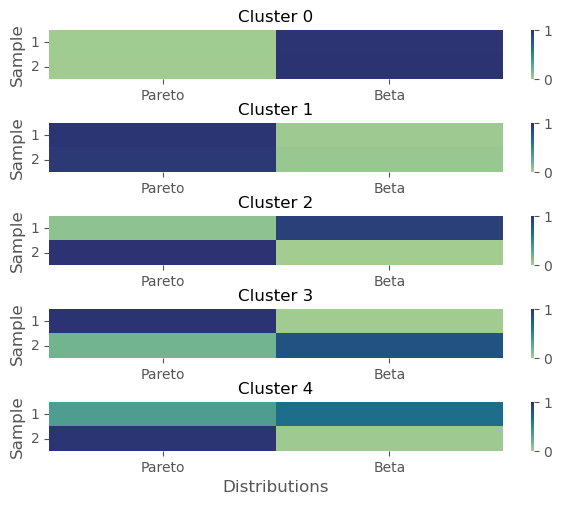

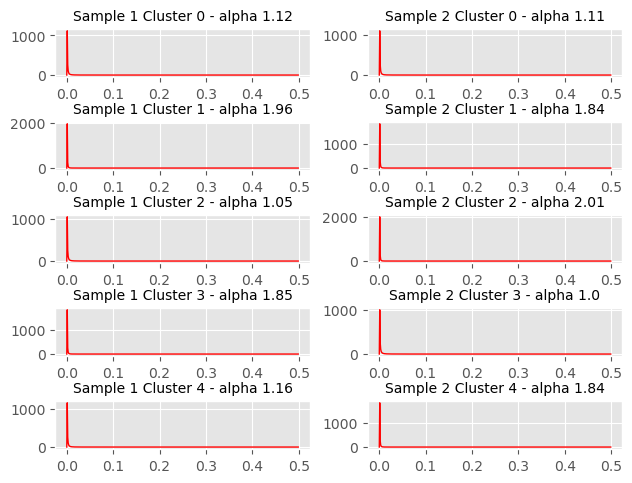

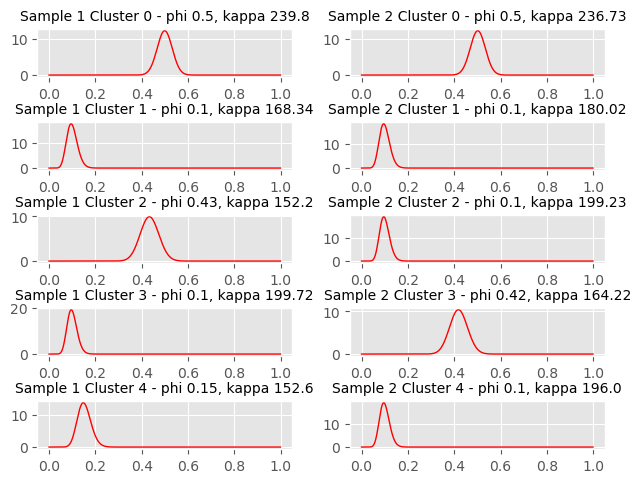

In [15]:
plot_marginals(final_mb)
plot_deltas(final_mb)
plot_paretos(final_mb)
plot_betas(final_mb)

In [16]:
final_mb.params

{'weights_param': tensor([0.1820, 0.4048, 0.1303, 0.1115, 0.1715], dtype=torch.float64,
        grad_fn=<DivBackward0>),
 'alpha_pareto_param': tensor([[1.1184, 1.1111],
         [1.9647, 1.8394],
         [1.0515, 2.0071],
         [1.8469, 0.9953],
         [1.1611, 1.8441]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[0.4993, 0.5017],
         [0.1000, 0.1000],
         [0.4339, 0.1000],
         [0.1000, 0.4190],
         [0.1524, 0.1000]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[239.8008, 236.7251],
         [168.3396, 180.0233],
         [152.2041, 199.2348],
         [199.7223, 164.2205],
         [152.6040, 196.0022]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[0.0181, 0.9819],
          [0.0143, 0.9857]],
 
         [[0.9753, 0.0247],
          [0.9532, 0.0468]],
 
         [[0.0846, 0.9154],
          [0.9894, 0.0106]],
 
         [[0.9860, 0.0140],
          [0.1829, 0.8171]],
 
         [[0.3411, 0.6589],
          [0.9739, 0.0261]]], grad_fn=<Di

### rRACES longitudinal data

In [3]:
NV_r = pd.read_csv("./rRACES_data/NV_long.csv")
DP_r = pd.read_csv("./rRACES_data/DP_long.csv")

NV = torch.tensor(NV_r.to_numpy())
DP = torch.tensor(DP_r.to_numpy())

print(NV.shape)
print(DP.shape)

torch.Size([1224, 2])
torch.Size([1224, 2])


In [4]:
torch.sum((NV[:,0]/DP[:,0] < 0.15) & (NV[:,0]/DP[:,0] > 0.))

tensor(424)

In [5]:
# Replace zeros with a large value that will not be considered as minimum
vaf = NV[:,0]/DP[:,0]
copy_vaf = torch.clone(vaf)
masked_tensor = copy_vaf.masked_fill(vaf == 0, float(1.))

# Find the minimum value excluding zeros
min_value = torch.min(masked_tensor)
print(min_value)

# Replace zeros with a large value that will not be considered as minimum
vaf = NV[:,1]/DP[:,1]
copy_vaf = torch.clone(vaf)
masked_tensor = copy_vaf.masked_fill(vaf == 0, float(1.))

# Find the minimum value excluding zeros
min_value = torch.min(masked_tensor)
print(min_value)

tensor(0.0094)
tensor(0.0095)


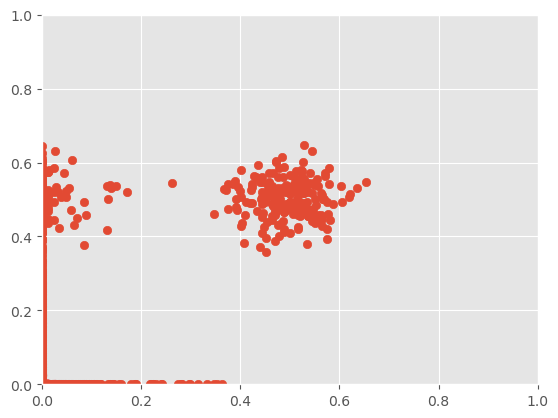

In [6]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1])

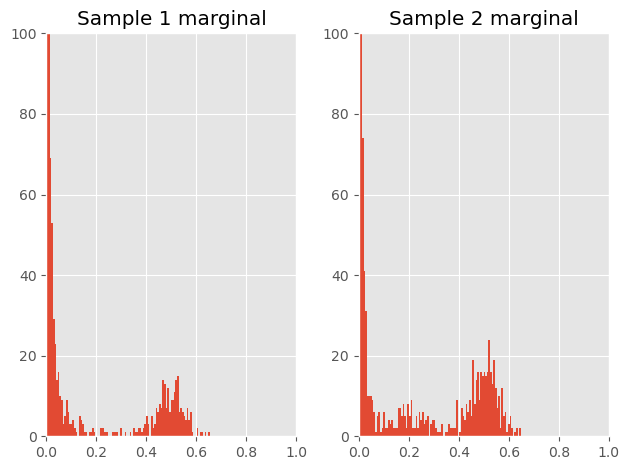

In [7]:
# plt.figure(figsize=(10, 5))

# First subplot for Sample 1 marginal
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
# Plot marginal of S1
plt.hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 100)
plt.title("Sample 1 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Second subplot for Sample 2 marginal
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 100)
plt.title("Sample 2 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Display the plots
plt.tight_layout()
plt.show()

kmeans_centers:  tensor([[1.4442e-02, 1.1785e-02],
        [4.9358e-01, 5.0280e-01],
        [1.6109e-02, 4.9525e-01],
        [2.2913e-01, 1.4901e-08],
        [1.4901e-08, 2.1557e-01]])


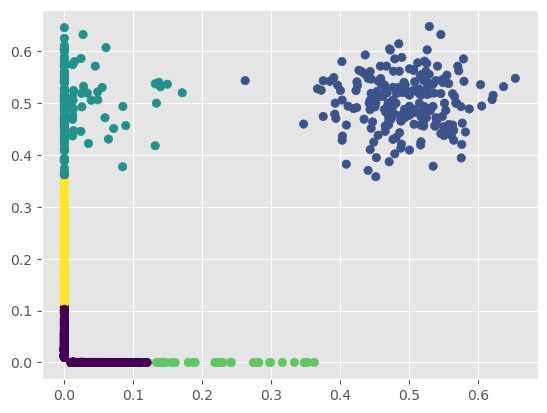

In [8]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=123, n_init="auto").fit((NV/DP).numpy())
cluster = kmeans.labels_
centers = torch.tensor(kmeans.cluster_centers_)
centers[centers <= 0] = 0.001
centers[centers >= 1] = 0.999

print("kmeans_centers: ", centers)

sc = plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = cluster)

RUN WITH K = 5 AND SEED = 40
NV = 0 before: tensor(965)
NV = 0 after: tensor(965)
delta_param tensor([[[0.3992, 0.6008],
         [0.4028, 0.5972]],

        [[0.6042, 0.3958],
         [0.4042, 0.5958]],

        [[0.4043, 0.5957],
         [0.4042, 0.5958]],

        [[0.3960, 0.6040],
         [0.4044, 0.5956]],

        [[0.3960, 0.6040],
         [0.6040, 0.3960]]], grad_fn=<DivBackward0>)
Iteration 0: Loss = 9667181.218276024
Iteration 200: Loss = 8378602.860245705
Iteration 400: Loss = 8563805.271439552
Iteration 600: Loss = 8667509.96601963
Iteration 800: Loss = 7767619.638627052
Iteration 1000: Loss = 8016712.499466896
Iteration 1200: Loss = 8537165.956009865
Iteration 1400: Loss = 7348366.254349709
Iteration 1600: Loss = 7793398.791947365
Iteration 1800: Loss = 8820129.803177834
Iteration 2000: Loss = 8378946.28218174
Iteration 2200: Loss = 7546939.73921299
Iteration 2400: Loss = 8502245.992142677
Iteration 2600: Loss = 10284397.900345802
Iteration 2800: Loss = 7609825.866166

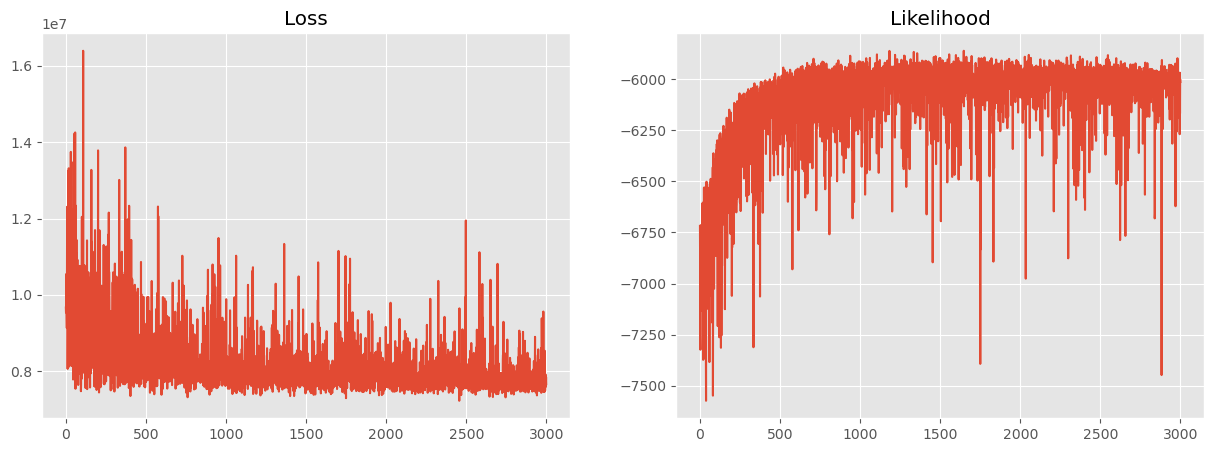

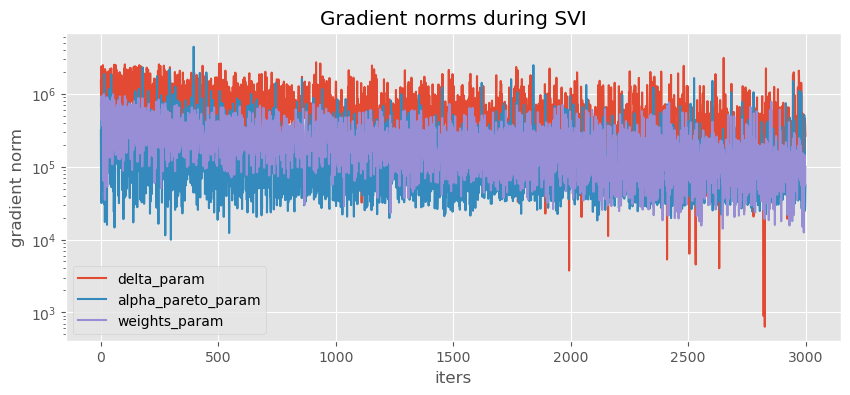

bic:  tensor(64942.1406, grad_fn=<RsubBackward1>)


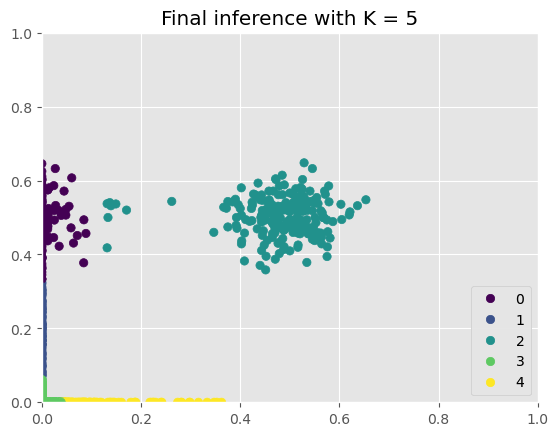

RUN WITH K = 5 AND SEED = 41
NV = 0 before: tensor(965)
NV = 0 after: tensor(965)
delta_param tensor([[[0.4040, 0.5960],
         [0.4040, 0.5960]],

        [[0.6042, 0.3958],
         [0.4006, 0.5994]],

        [[0.4026, 0.5974],
         [0.3960, 0.6040]],

        [[0.4042, 0.5958],
         [0.4042, 0.5958]],

        [[0.4043, 0.5957],
         [0.6042, 0.3958]]], grad_fn=<DivBackward0>)
Iteration 0: Loss = 11033636.230294228
Iteration 200: Loss = 10974478.94221592
Iteration 400: Loss = 9634997.9427042
Iteration 600: Loss = 8265647.926468849
Iteration 800: Loss = 7773214.20405674
Iteration 1000: Loss = 7816185.073197365
Iteration 1200: Loss = 7957319.63374424
Iteration 1400: Loss = 8803613.581986427
Iteration 1600: Loss = 7789709.794388771
Iteration 1800: Loss = 7510386.583939552
Iteration 2000: Loss = 7998164.67280674
Iteration 2200: Loss = 7841934.515091896
Iteration 2400: Loss = 7875140.988724709
Iteration 2600: Loss = 8569658.366654396
Iteration 2800: Loss = 7596627.97456455

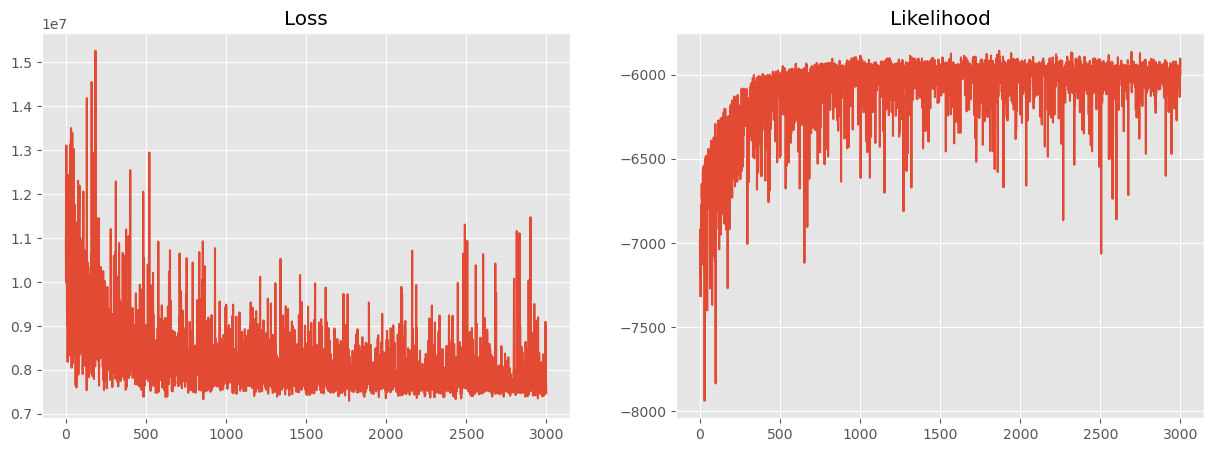

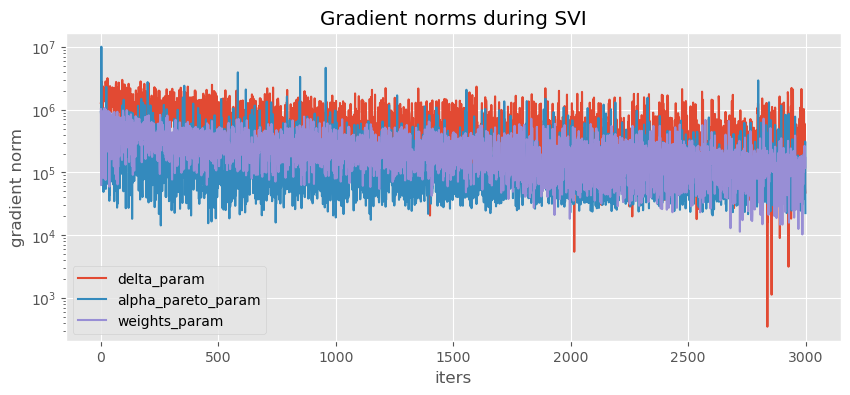

bic:  tensor(65110.6758, grad_fn=<RsubBackward1>)


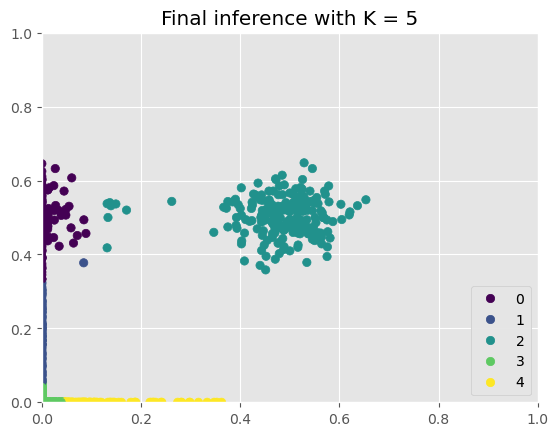

RUN WITH K = 5 AND SEED = 42
NV = 0 before: tensor(965)
NV = 0 after: tensor(965)
delta_param tensor([[[0.4042, 0.5958],
         [0.4046, 0.5954]],

        [[0.6043, 0.3957],
         [0.3957, 0.6043]],

        [[0.4040, 0.5960],
         [0.3959, 0.6041]],

        [[0.4043, 0.5957],
         [0.4042, 0.5958]],

        [[0.4047, 0.5953],
         [0.6042, 0.3958]]], grad_fn=<DivBackward0>)
Iteration 0: Loss = 9547698.230294228
Iteration 200: Loss = 8044141.451737404
Iteration 400: Loss = 8200626.592972755
Iteration 600: Loss = 8386107.795365334
Iteration 800: Loss = 8181075.00483799
Iteration 1000: Loss = 10226915.952103615
Iteration 1200: Loss = 7611071.402787209
Iteration 1400: Loss = 7512190.507767677
Iteration 1600: Loss = 8614024.865189552
Iteration 1800: Loss = 7711670.040482521
Iteration 2000: Loss = 8751983.402298927
Iteration 2200: Loss = 7874595.66108799
Iteration 2400: Loss = 7529863.209427834
Iteration 2600: Loss = 7816502.931107521
Iteration 2800: Loss = 7566031.65522

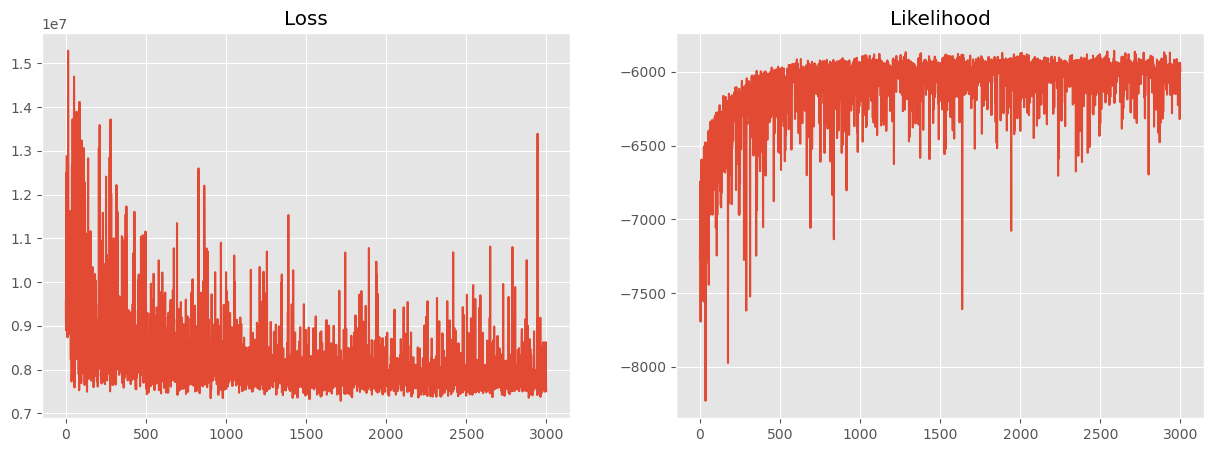

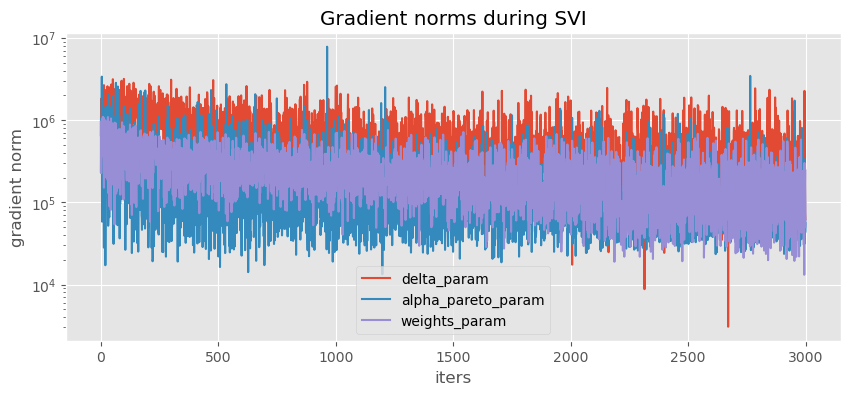

bic:  tensor(67924.7109, grad_fn=<RsubBackward1>)


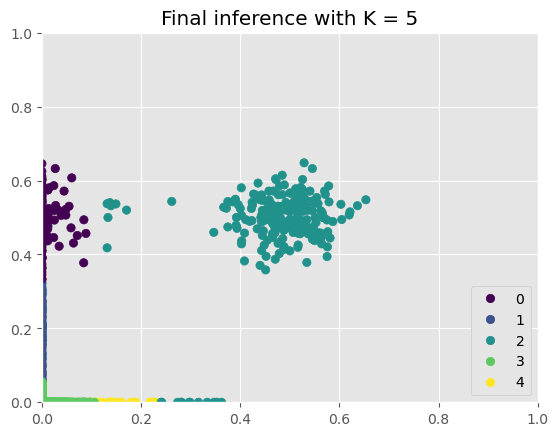

Selected number of clusters is 5 with seed 40


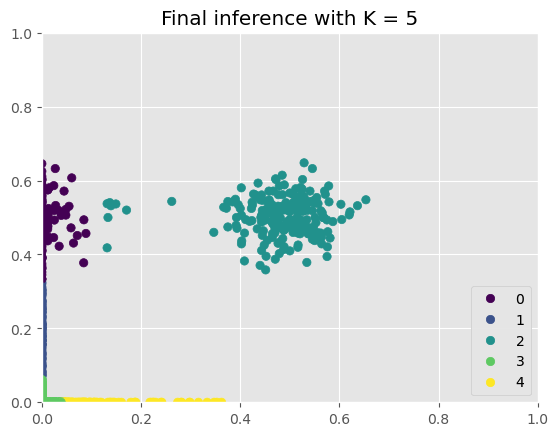

In [9]:
final_mb, mb_list = model_mobster_mv.fit(NV, DP, num_iter = 3000, K = [5], seed = [40,41,42], lr = 0.005)

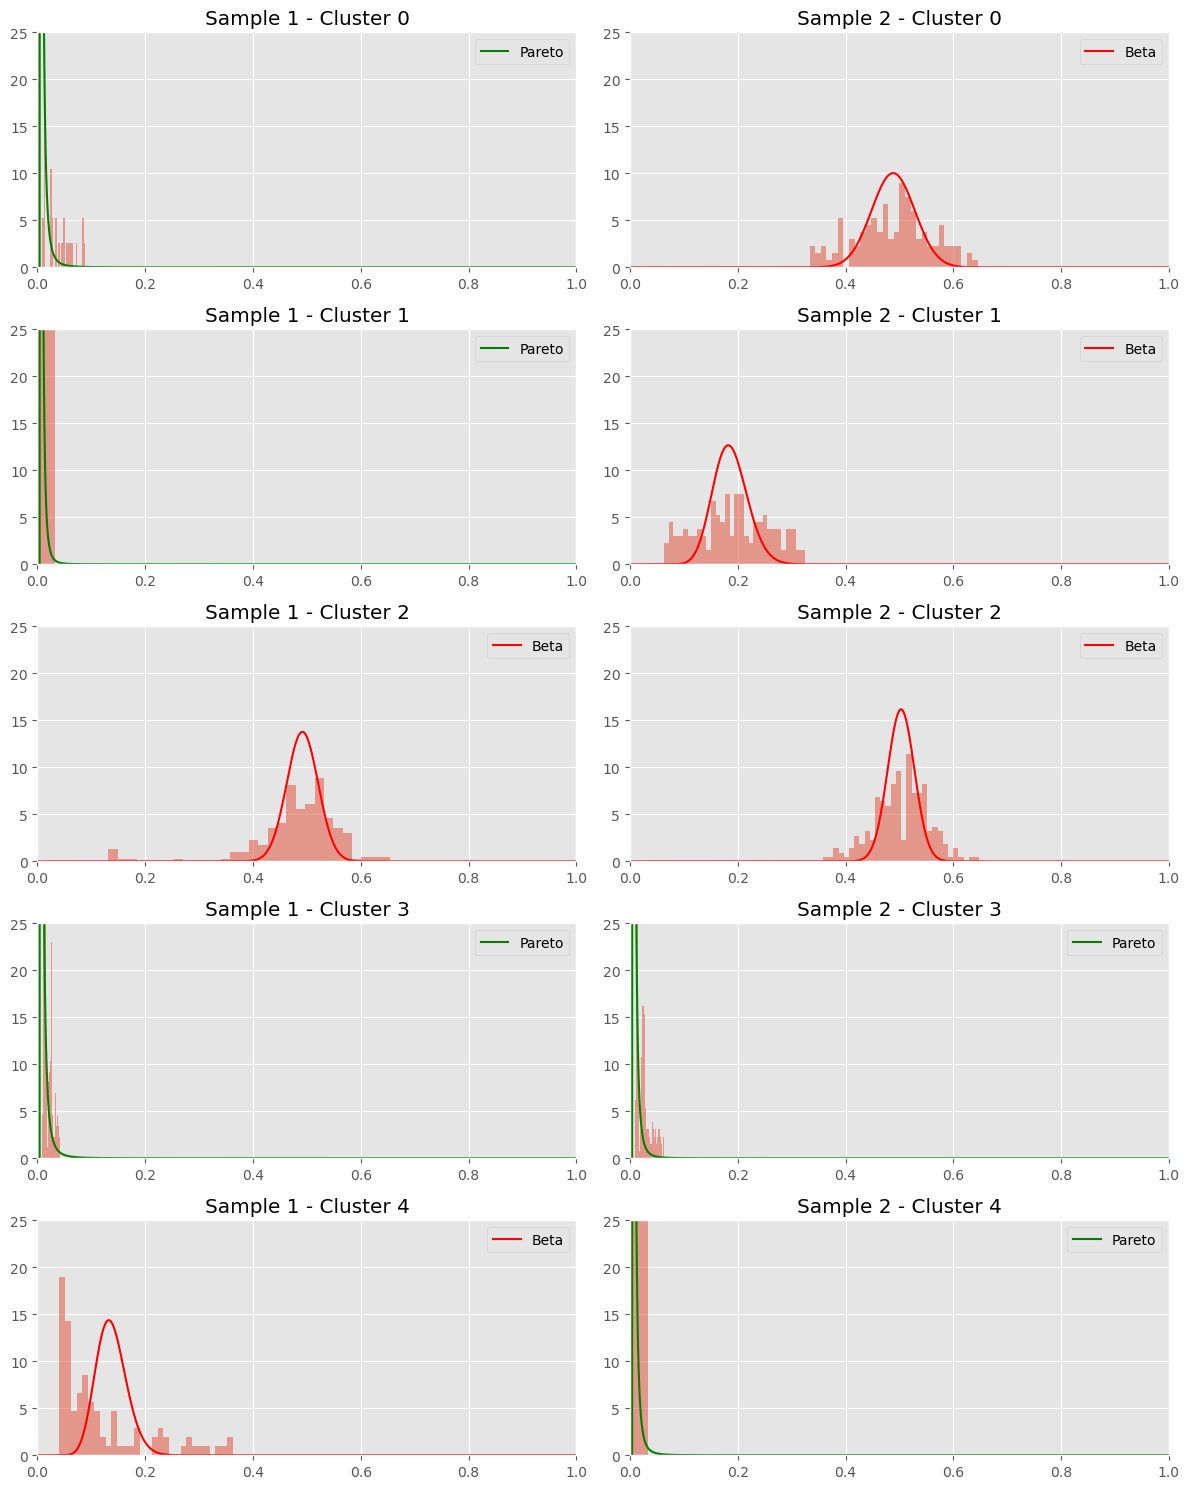

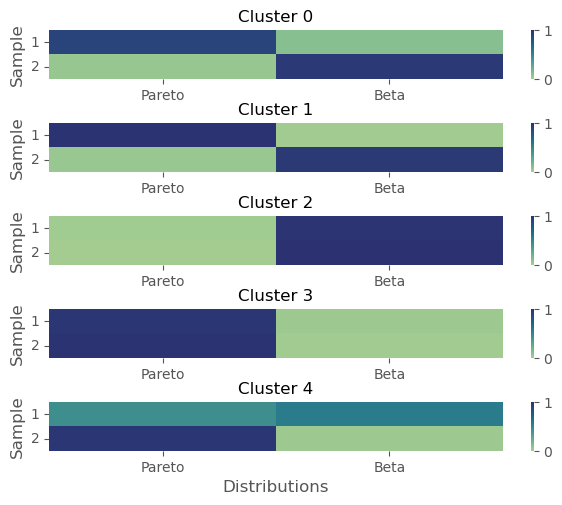

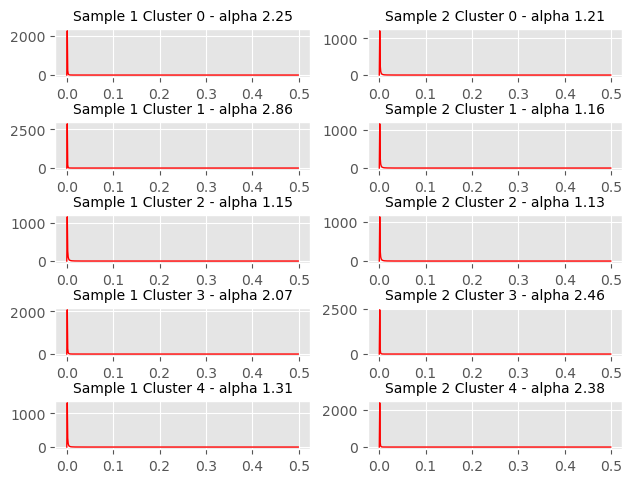

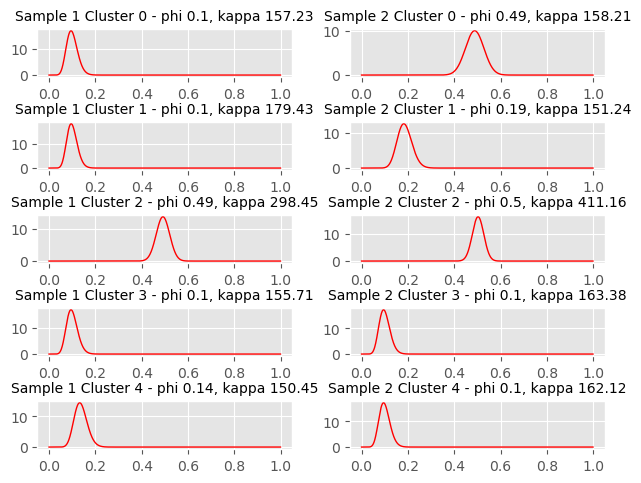

In [10]:
plot_marginals(final_mb)
plot_deltas(final_mb)
plot_paretos(final_mb)
plot_betas(final_mb)

In [11]:
final_mb.params

{'weights_param': tensor([0.1144, 0.1352, 0.1816, 0.4390, 0.1298], dtype=torch.float64,
        grad_fn=<DivBackward0>),
 'alpha_pareto_param': tensor([[2.2464, 1.2096],
         [2.8588, 1.1572],
         [1.1535, 1.1251],
         [2.0691, 2.4609],
         [1.3089, 2.3770]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[0.1000, 0.4884],
         [0.1000, 0.1865],
         [0.4916, 0.5029],
         [0.1000, 0.1000],
         [0.1372, 0.1000]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[157.2252, 158.2113],
         [179.4272, 151.2379],
         [298.4548, 411.1562],
         [155.7134, 163.3846],
         [150.4542, 162.1190]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[0.8958, 0.1042],
          [0.0470, 0.9530]],
 
         [[0.9878, 0.0122],
          [0.0456, 0.9544]],
 
         [[0.0174, 0.9826],
          [0.0073, 0.9927]],
 
         [[0.9701, 0.0299],
          [0.9855, 0.0145]],
 
         [[0.4389, 0.5611],
          [0.9705, 0.0295]]], grad_fn=<Di